## Table of Contents
1. [Introduction](#intro)
2. [Libraries](#libs)
3. [Definitions](#defs)
4. [Data Exploration](#dataexp)
    1. [Spray](#sprayex)
    2. [Weather](#wthrex)
    3. [Training Data](#trainex)
    4. [Test Data](#testex)
5. [Data Prep](#dataprep)
    1. [Spray](#sprayprep)
    2. [Weather](#wthrprep)
    3. [Training & Testing Data](#trainprep)
4. [Models - Training](#analysis)
    1. [2007](#train07)
    2. [2009](#train09)
    3. [2011](#train11)
    4. [2013](#train13)
5. [Models - Testing](#testing)
    1. [2008](#test08)
    2. [2010](#test10)
    3. [2012](#test12)
    4. [2014](#test14)
    5. [Predictions](#predict)
6. [Conclusion](#conclusion)

# Introduction <a name="intro"></a>

This is work from an old Kaggle competition called "Predict West Nile Virus". 

The data collected is based on Mosquitos in Chicago between 2007 and 2014. There were traps set up and the mosquitos were collected and checked for West Nile Virus (WNV). For the odd years, 2007, 2009, 2011, and 2013, there is information about whether or not WNV virus was found. This data makes up the "Train" data. Conquently, the even years, 2008, 2010, 2012, and 2014, make up the "Train" data. 

This challenge is to take the training data and predict WNV or not for the Test data. 

Some additional information provided was daily weather & various weather related attributes for May 2007 - Oct 2014 from two different locations - Chicago O'Hare Int'l Airport & Chicago Midway Int'l Airport. Information regarding spraying against the virus is provided in "Spray". However, information for location and times of sprays are only provided for 2011 and 2013. Untimately, I decided not to use the Spray data, but did incorporate the weather data.


At a high level, I tried to use past training data to predict the future test data. For example use 2007 to predict 2008, use 2009 (& 2007) to predict 2010, etc. My analysis can be broken down into several steps, as seen above in the index - Data Exploration, Data Prep, Logistic Regression with Regularization (L1 or L2 penalty) on the training data, and then using those models to predict WNV for the even years. 

# Libraries <a name="libs"></a>

In [1]:
##################################################################
##################################################################
#
#                   LIBRARIES
#
##################################################################
##################################################################
import collections
import csv
import datetime as dt
import folium
import itertools as it
import math
import matplotlib.pyplot as plt
import missingno as msno
import networkx as nx
import numpy as np
import os
import pandas as pd
import re
import requests
import scipy
import seaborn as sns
import sklearn
import statsmodels.api as sm
import sys

from collections import Counter, defaultdict
from datetime import datetime, timedelta
from folium import plugins
from folium.plugins import HeatMap
from geopy.distance import vincenty, great_circle
from itertools import count, zip_longest
from operator import itemgetter, attrgetter
from seaborn import catplot
from sklearn import datasets, preprocessing, model_selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV


# Definitions <a name="defs"></a>

In [2]:
##################################################################
##################################################################
#
#                   DEFINITIONS
#
##################################################################
##################################################################

def daylight(rise, sunset):
    daylight = np.zeros(rise.shape)
    for i, val in enumerate(rise):
        rise_hr = int(str(val)[:1])
        rise_min = int(str(val)[-2:])
        sunset_hr = int(str(sunset[i])[:2])
        sunset_min = int(str(sunset[i])[-2:])
        if sunset_min == 60:
            sunset_hr = sunset_hr +1
            sunset_min = int(str('00'))
        hours = sunset_hr - rise_hr
        daylight[i] = (sunset_min - rise_min) + (hours * 60)
    return daylight

def distance_calc (row):
    start = (row['Latitude'], row['Longitude'])
    #stop = (row['stop_latitude'], row['stop_longitude'])
    dist_1 = great_circle(start, station1).meters
    dist_2 = great_circle(start, station2).meters
    if dist_1 < dist_2:
        #dist = dist_1
        stat = 1
    else:
        #dist = dist_2
        stat = 2
    return stat




In [3]:
##################################################################
##################################################################
#
#                     Inputs
#
##################################################################
##################################################################

spray = pd.read_csv('spray.csv')
wthr = pd.read_csv('weather.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

pd.set_option('display.max_columns', 500)  # <-- needed bc the wthr data has too many columns,so this lets us see ALL columns.


## Station information
#Station 1 = Chicago O'Hare Airport
lat_stat1 = 41.995
long_stat1 = -87.933
evel_stat1 = 662 #feet
station1 = (lat_stat1, long_stat1)
#Station 2 = Chicago Midway Airport
lat_stat2 = 41.786
long_stat2 = -87.752
evel_stat2 = 612 #feet
station2 = (lat_stat2, long_stat2)

# Data Exploration <a name="dataexp"></a>

## Spray Data <a name="sprayex"></a>

In [4]:
####################################################################################
####################################################################################
#           Spray Data Exploration
###################################################################################
####################################################################################
spray.dtypes

Date          object
Time          object
Latitude     float64
Longitude    float64
dtype: object

In [5]:
# Date & Time cleanup
spray['Date'] = pd.to_datetime(spray['Date'])
spray['Time'] = pd.to_datetime(spray['Time'])
spray['Time'] = spray['Time'].dt.time

In [6]:
len(spray)

14835

In [7]:
display(spray.head(10))
display(spray.describe())
print('Min Date: ', min(spray['Date']))
print('Max Date: ', max(spray['Date']))
print('Min Time: ', min(spray['Time']))
print('Max Time: ', max(spray['Time']))

,Date,Time,Latitude,Longitude
0,2011-08-29,18:56:58,42.391623,-88.089163
1,2011-08-29,18:57:08,42.391348,-88.089163
2,2011-08-29,18:57:18,42.391022,-88.089157
3,2011-08-29,18:57:28,42.390637,-88.089158
4,2011-08-29,18:57:38,42.390410,-88.088858
5,2011-08-29,18:57:48,42.390395,-88.088315
6,2011-08-29,18:57:58,42.390673,-88.088002
7,2011-08-29,18:58:08,42.391027,-88.088002
8,2011-08-29,18:58:18,42.391403,-88.088003
9,2011-08-29,18:58:28,42.391718,-88.087995


,Latitude,Longitude
count,14835.000000,14835.000000
mean,41.904828,-87.736690
std,0.104381,0.067292
min,41.713925,-88.096468
25%,41.785001,-87.794225
50%,41.940075,-87.727853
75%,41.980978,-87.694108
max,42.395983,-87.586727


Min Date:  2011-08-29 00:00:00
Max Date:  2013-09-05 00:00:00
Min Time:  00:00:01
Max Time:  23:59:58


In [8]:
#check for missing values
print('Missing values: ')
print(spray.isnull().sum())

Missing values: 
Date           0
Time         584
Latitude       0
Longitude      0
dtype: int64


In [9]:
spray[spray.Time.isnull()]

,Date,Time,Latitude,Longitude
1625,2011-09-07,NaN,41.987092,-87.794286
1626,2011-09-07,NaN,41.987620,-87.794382
1627,2011-09-07,NaN,41.988004,-87.794574
1628,2011-09-07,NaN,41.988292,-87.795486
1629,2011-09-07,NaN,41.988100,-87.796014
1630,2011-09-07,NaN,41.986372,-87.794862
1631,2011-09-07,NaN,41.986228,-87.795582
1632,2011-09-07,NaN,41.984836,-87.793998
1633,2011-09-07,NaN,41.984836,-87.794670
1634,2011-09-07,NaN,41.984884,-87.795198


In [10]:
spray[spray.Time.isnull()].Date.value_counts()

2011-09-07    584
Name: Date, dtype: int64

In [11]:
spray.Date.value_counts()

2013-08-15    2668
2013-08-29    2302
2013-07-17    2202
2011-09-07    2114
2013-07-25    1607
2013-08-22    1587
2013-08-08    1195
2013-09-05     924
2013-08-16     141
2011-08-29      95
Name: Date, dtype: int64

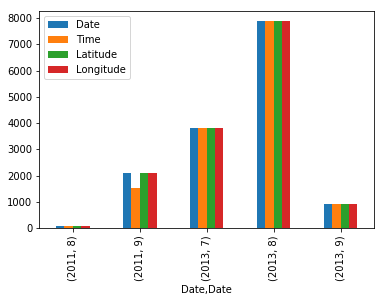

In [12]:
# PLOTS
spray.groupby([spray["Date"].dt.year, spray["Date"].dt.month]).count().plot(kind="bar")

From looking at the data intself, 3.9% of spray data has missing times, but they all happen to be on the same date 9/7/2011. Thus, to fill in the missing times, I can generate times between the first and last times that were listed for that date (since not all times on the day were missing, just some). The first time was 19:42:12 and the last was 21:41:10. In the data prep section I will generate those times and then apply random times from that range to fill in the missing times in the spray dataframe.

## Weather <a name="wthrex"></a>

In [13]:
wthr = pd.read_csv('weather.csv')

In [14]:
####################################
####################################
#        Weather Data Exploration
####################################
####################################
print(wthr.dtypes)
wthr.head()

Station          int64
Date            object
Tmax             int64
Tmin             int64
Tavg            object
Depart          object
DewPoint         int64
WetBulb         object
Heat            object
Cool            object
Sunrise         object
Sunset          object
CodeSum         object
Depth           object
Water1          object
SnowFall        object
PrecipTotal     object
StnPressure     object
SeaLevel        object
ResultSpeed    float64
ResultDir        int64
AvgSpeed        object
dtype: object


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,5/1/07,83,50,67,14,51,56,0,2,448,1849,,0,M,0,0,29.1,29.82,1.7,27,9.2
1,2,5/1/07,84,52,68,M,51,57,0,3,-,-,,M,M,M,0,29.18,29.82,2.7,25,9.6
2,1,5/2/07,59,42,51,-3,42,47,14,0,447,1850,BR,0,M,0,0,29.38,30.09,13.0,4,13.4
3,2,5/2/07,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0,29.44,30.08,13.3,2,13.4
4,1,5/3/07,66,46,56,2,40,48,9,0,446,1851,,0,M,0,0,29.39,30.12,11.7,7,11.9


In [15]:
wthr['Date'] = pd.to_datetime(wthr['Date'])

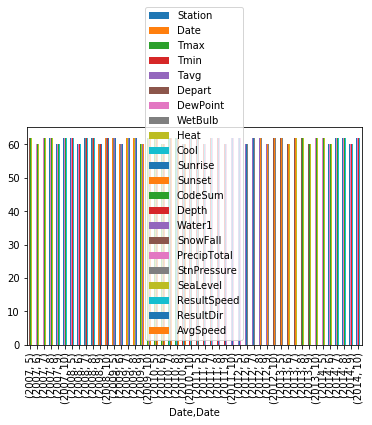

In [16]:
wthr.groupby([wthr["Date"].dt.year, wthr["Date"].dt.month]).count().plot(kind="bar")

weather data includes the following dates:
    2007: May - Oct
    2008: May - Oct
    2009: May - Oct
    2010: May - Oct
    2011: May - Oct
    2012: May - Oct
    2013: May - Oct
    2014: May - Oct

In [17]:
wthr['Station'].value_counts()

1    1472
2    1472
Name: Station, dtype: int64

In [18]:
## Station information as per the Kaggle website
#Station 1 = Chicago O'Hare Airport
lat_stat1 = 41.995
long_stat1 = -87.933
evel_stat1 = 662 #feet
#Station 2 = Chicago Midway Airport
lat_stat2 = 41.786
long_stat2 = -87.752
evel_stat2 = 612 #feet

In [19]:
display(wthr.describe())
#check for missing values
print('Missing values: ')
print(wthr.isnull().sum())

,Station,Tmax,Tmin,DewPoint,ResultSpeed,ResultDir
count,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000
mean,1.500000,76.166101,57.810462,53.457880,6.960666,17.494905
std,0.500085,11.461970,10.381939,10.675181,3.587527,10.063609
min,1.000000,41.000000,29.000000,22.000000,0.100000,1.000000
25%,1.000000,69.000000,50.000000,46.000000,4.300000,7.000000
50%,1.500000,78.000000,59.000000,54.000000,6.400000,19.000000
75%,2.000000,85.000000,66.000000,62.000000,9.200000,25.000000
max,2.000000,104.000000,83.000000,75.000000,24.100000,36.000000


Missing values: 
Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
CodeSum        0
Depth          0
Water1         0
SnowFall       0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
dtype: int64


In [20]:
wthr.Tavg.unique()

array(['67', '68', '51', '52', '56', '58', 'M', '60', '59', '65', '70',
       '69', '71', '61', '55', '57', '73', '72', '53', '62', '63', '74',
       '75', '78', '76', '77', '66', '80', '64', '81', '82', '79', '85',
       '84', '83', '50', '49', '46', '48', '45', '54', '47', '44', '40',
       '41', '38', '39', '42', '37', '43', '86', '87', '89', '92', '88',
       '91', '93', '94', '90', '36'], dtype=object)

In [21]:
wthr[wthr['Tavg']=='M']

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0,29.36,30.04,10.1,7,10.4
505,2,2008-07-08,86,46,M,M,68,71,M,M,-,-,TS RA,M,M,M,0.28,29.16,29.8,7.4,24,8.3
675,2,2008-10-01,62,46,M,M,41,47,M,M,-,-,,M,M,M,0,29.3,29.96,10.9,33,11
1637,2,2011-07-22,100,71,M,M,70,74,M,M,-,-,TS TSRA BR,M,M,M,0.14,29.23,29.86,3.8,10,8.2
2067,2,2012-08-22,84,72,M,M,51,61,M,M,-,-,,M,M,M,0,29.39,M,4.7,19,M
2211,2,2013-05-02,71,42,M,M,39,45,M,M,-,-,,M,M,M,0,29.51,30.17,15.8,2,16.1
2501,2,2013-09-24,91,52,M,M,48,54,M,M,-,-,,M,M,M,0,29.33,30,5.8,9,7.7
2511,2,2013-09-29,84,53,M,M,48,54,M,M,-,-,RA BR,M,M,M,0.22,29.36,30.01,6.3,36,7.8
2525,2,2013-10-06,76,48,M,M,44,50,M,M,-,-,RA DZ BR,M,M,M,0.06,29.1,29.76,10.1,25,10.6
2579,2,2014-05-02,80,47,M,M,43,47,M,M,-,-,RA,M,M,M,0.04,29.1,29.79,10.7,23,11.9


In [22]:
print(wthr.Depart.unique())
wthr[wthr['Depart'] == 'M']

['14' 'M' '-3' '2' '4' '5' '10' '12' '13' '-2' '15' '11' '-4' '-6' '8'
 '-5' '1' '9' '6' '-9' '-8' '3' '0' '-1' '-7' '7' '-14' '18' '16' '22'
 '21' '20' '-10' '-16' '17' '-12' '-11' '-15' '-17' '19' '-13' '23']


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0,29.18,29.82,2.7,25,9.6
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0,29.44,30.08,13.3,2,13.4
5,2,2007-05-03,67,48,58,M,40,50,7,0,-,-,HZ,M,M,M,0,29.46,30.12,12.9,6,13.2
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0,29.36,30.04,10.1,7,10.4
9,2,2007-05-05,66,54,60,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5
11,2,2007-05-06,68,52,60,M,30,46,5,0,-,-,,M,M,M,0,29.62,30.28,13.8,10,14.5
13,2,2007-05-07,84,50,67,M,39,53,0,2,-,-,,M,M,M,0,29.44,30.12,8.5,17,9.9
15,2,2007-05-08,80,60,70,M,57,63,0,5,-,-,HZ,M,M,M,T,29.36,30.02,2.5,8,5.4
17,2,2007-05-09,76,63,70,M,60,63,0,5,-,-,BR HZ,M,M,M,0.02,29.28,29.93,3.9,7,5.9
19,2,2007-05-10,83,59,71,M,52,61,0,6,-,-,BR HZ,M,M,M,0,29.26,29.91,2.0,9,3.9


In [23]:
print(wthr.WetBulb.unique())
wthr[wthr['WetBulb'] == 'M']

['56' '57' '47' '48' '50' '49' '46' '54' '53' '62' '63' '60' '61' '51'
 '59' '58' '43' '44' '45' '65' '66' '67' '64' '52' '55' '69' '68' '70'
 '72' '71' '73' '74' '76' '42' '39' '40' '41' '35' '33' '34' 'M' '75' '36'
 '32' '38' '78' '77' '37']


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
848,1,2009-06-26,86,69,78,7,60,M,0,13,418,1931,,0,M,0,0,M,29.85,6.4,4,8.2
2410,1,2013-08-10,81,64,73,0,57,M,0,8,454,1900,,0,M,0,0,M,30.08,5.3,5,6.5
2412,1,2013-08-11,81,60,71,-2,61,M,0,6,455,1859,RA,0,M,0,0.01,29.35,30.07,2.0,27,3
2415,2,2013-08-12,85,69,77,M,63,M,0,12,-,-,RA,M,M,M,0.66,29.27,29.92,4.5,26,7.7


In [24]:
print(wthr.Heat.unique())
wthr[wthr['Heat'] == 'M']

['0' '14' '13' '9' '7' 'M' '5' '6' '4' '10' '8' '12' '3' '2' '1' '15' '16'
 '19' '17' '20' '11' '18' '21' '25' '24' '27' '26' '23' '28' '22' '29']


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0,29.36,30.04,10.1,7,10.4
505,2,2008-07-08,86,46,M,M,68,71,M,M,-,-,TS RA,M,M,M,0.28,29.16,29.8,7.4,24,8.3
675,2,2008-10-01,62,46,M,M,41,47,M,M,-,-,,M,M,M,0,29.3,29.96,10.9,33,11
1637,2,2011-07-22,100,71,M,M,70,74,M,M,-,-,TS TSRA BR,M,M,M,0.14,29.23,29.86,3.8,10,8.2
2067,2,2012-08-22,84,72,M,M,51,61,M,M,-,-,,M,M,M,0,29.39,M,4.7,19,M
2211,2,2013-05-02,71,42,M,M,39,45,M,M,-,-,,M,M,M,0,29.51,30.17,15.8,2,16.1
2501,2,2013-09-24,91,52,M,M,48,54,M,M,-,-,,M,M,M,0,29.33,30,5.8,9,7.7
2511,2,2013-09-29,84,53,M,M,48,54,M,M,-,-,RA BR,M,M,M,0.22,29.36,30.01,6.3,36,7.8
2525,2,2013-10-06,76,48,M,M,44,50,M,M,-,-,RA DZ BR,M,M,M,0.06,29.1,29.76,10.1,25,10.6
2579,2,2014-05-02,80,47,M,M,43,47,M,M,-,-,RA,M,M,M,0.04,29.1,29.79,10.7,23,11.9


In [25]:
print(wthr.Sunrise.unique())
wthr[wthr['Sunrise'] == '-']

['448' '-' '447' '446' '444' '443' '442' '441' '439' '438' '437' '436'
 '435' '434' '433' '432' '431' '430' '429' '428' '427' '426' '425' '424'
 '423' '422' '421' '420' '419' '418' '417' '416' '440' '445' '449' '450'
 '451' '452' '453' '454' '455' '456' '457' '458' '459' '500' '501' '502'
 '503' '504' '505' '506' '508' '509' '510' '511' '512' '513' '514' '515'
 '516' '517' '518' '519' '520' '521' '522' '523' '524' '525' '526' '527'
 '528' '529' '530' '531' '532' '533' '535' '536' '537' '538' '539' '540'
 '541' '542' '543' '544' '545' '546' '547' '548' '549' '550' '552' '553'
 '554' '555' '556' '557' '558' '559' '600' '602' '603' '604' '605' '606'
 '607' '608' '610' '611' '612' '613' '614' '616' '617' '618' '619' '620'
 '622' '623']


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0,29.18,29.82,2.7,25,9.6
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0,29.44,30.08,13.3,2,13.4
5,2,2007-05-03,67,48,58,M,40,50,7,0,-,-,HZ,M,M,M,0,29.46,30.12,12.9,6,13.2
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0,29.36,30.04,10.1,7,10.4
9,2,2007-05-05,66,54,60,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5
11,2,2007-05-06,68,52,60,M,30,46,5,0,-,-,,M,M,M,0,29.62,30.28,13.8,10,14.5
13,2,2007-05-07,84,50,67,M,39,53,0,2,-,-,,M,M,M,0,29.44,30.12,8.5,17,9.9
15,2,2007-05-08,80,60,70,M,57,63,0,5,-,-,HZ,M,M,M,T,29.36,30.02,2.5,8,5.4
17,2,2007-05-09,76,63,70,M,60,63,0,5,-,-,BR HZ,M,M,M,0.02,29.28,29.93,3.9,7,5.9
19,2,2007-05-10,83,59,71,M,52,61,0,6,-,-,BR HZ,M,M,M,0,29.26,29.91,2.0,9,3.9


In [26]:
print(wthr.Depth.unique())
wthr[wthr['Depth'] == 'M']

['0' 'M']


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
1,2,2007-05-01,84,52,68,M,51,57,0,3,-,-,,M,M,M,0,29.18,29.82,2.7,25,9.6
3,2,2007-05-02,60,43,52,M,42,47,13,0,-,-,BR HZ,M,M,M,0,29.44,30.08,13.3,2,13.4
5,2,2007-05-03,67,48,58,M,40,50,7,0,-,-,HZ,M,M,M,0,29.46,30.12,12.9,6,13.2
7,2,2007-05-04,78,51,M,M,42,50,M,M,-,-,,M,M,M,0,29.36,30.04,10.1,7,10.4
9,2,2007-05-05,66,54,60,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5
11,2,2007-05-06,68,52,60,M,30,46,5,0,-,-,,M,M,M,0,29.62,30.28,13.8,10,14.5
13,2,2007-05-07,84,50,67,M,39,53,0,2,-,-,,M,M,M,0,29.44,30.12,8.5,17,9.9
15,2,2007-05-08,80,60,70,M,57,63,0,5,-,-,HZ,M,M,M,T,29.36,30.02,2.5,8,5.4
17,2,2007-05-09,76,63,70,M,60,63,0,5,-,-,BR HZ,M,M,M,0.02,29.28,29.93,3.9,7,5.9
19,2,2007-05-10,83,59,71,M,52,61,0,6,-,-,BR HZ,M,M,M,0,29.26,29.91,2.0,9,3.9


In [27]:
print(wthr.SnowFall.value_counts())

M      1472
0      1459
  T      12
0.1       1
Name: SnowFall, dtype: int64


In [28]:
print(wthr.PrecipTotal.value_counts())
wthr[wthr['PrecipTotal'] == '  T']

0       1577
  T      318
0.01     127
0.02      63
0.03      46
0.04      36
0.05      32
0.08      28
0.12      28
0.06      27
0.07      23
0.09      21
0.16      21
0.14      20
0.11      20
0.17      17
0.28      15
0.13      14
0.19      14
0.18      14
0.15      13
0.2       13
0.26      11
0.25      11
0.23      11
0.24      10
0.1       10
0.21       9
0.29       9
0.39       9
        ... 
2.35       1
1.48       1
1.34       1
1.88       1
3.15       1
0.98       1
1.22       1
2.24       1
1.18       1
2.68       1
1.96       1
6.64       1
2.43       1
2.79       1
2.17       1
1.58       1
1.75       1
3.97       1
2.9        1
1.6        1
1.19       1
1.24       1
1.11       1
0.62       1
1.3        1
2.2        1
0.91       1
1.35       1
1.49       1
1.44       1
Name: PrecipTotal, Length: 168, dtype: int64


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
6,1,2007-05-04,66,49,58,4,41,50,7,0,444,1852,RA,0,M,0,T,29.31,30.05,10.4,8,10.8
8,1,2007-05-05,66,53,60,5,38,49,5,0,443,1853,,0,M,0,T,29.4,30.1,11.7,7,12
9,2,2007-05-05,66,54,60,M,39,50,5,0,-,-,,M,M,M,T,29.46,30.09,11.2,7,11.5
12,1,2007-05-07,83,47,65,10,41,54,0,0,441,1856,RA,0,M,0,T,29.38,30.12,8.6,18,10.5
15,2,2007-05-08,80,60,70,M,57,63,0,5,-,-,HZ,M,M,M,T,29.36,30.02,2.5,8,5.4
47,2,2007-05-24,88,66,77,M,53,63,0,12,-,-,RA HZ,M,M,M,T,29.47,30.1,13.8,20,15.2
48,1,2007-05-25,70,56,63,1,44,53,2,0,423,1914,,0,M,0,T,29.51,30.24,4.9,5,8.8
54,1,2007-05-28,79,50,65,2,47,56,0,0,421,1916,RA,0,M,0,T,29.43,30.15,4.8,10,5.3
65,2,2007-06-02,81,68,75,M,62,67,0,10,-,-,RA BR,M,M,M,T,29.1,29.76,7.5,21,8.2
73,2,2007-06-06,73,48,61,M,47,55,4,0,-,-,RA,M,M,M,T,29.13,29.82,9.6,15,10.6


In [29]:
print(wthr.StnPressure.unique())
wthr[wthr['StnPressure'] == 'M']

['29.1' '29.18' '29.38' '29.44' '29.39' '29.46' '29.31' '29.36' '29.4'
 '29.57' '29.62' '29.29' '29.21' '29.28' '29.2' '29.26' '29.33' '29.49'
 '29.54' '29.55' '29.23' '29.13' '29.19' '29.53' '29.6' '29.34' '29.41'
 '29.47' '29.51' '29.42' '29.43' '29.25' '29.03' '28.82' '28.87' '28.88'
 '29.16' '29.07' '28.84' '28.91' '29.24' 'M' '29.3' '29.12' '29.45'
 '29.56' '29.32' '29.05' '29.11' '29.06' '29.22' '29.08' '29.14' '29.37'
 '29.35' '29.15' '29.17' '29.48' '29.52' '29.27' '29.5' '28.59' '28.67'
 '28.75' '29.02' '29.79' '29.86' '29.63' '29.7' '28.95' '29.01' '28.79'
 '28.85' '28.97' '28.89' '28.94' '28.93' '28.98' '28.96' '29' '29.66'
 '29.09' '28.9' '29.04' '29.59' '29.65' '29.58' '29.61' '29.64' '29.71'
 '29.67' '28.8' '28.73' '29.68' '28.74' '28.55' '28.63' '28.92' '28.99'
 '28.81' '28.71' '28.69' '28.77' '28.83']


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
87,2,2007-06-13,86,68,77,M,53,62,0,12,-,-,,M,M,M,0,M,M,7.0,5,M
848,1,2009-06-26,86,69,78,7,60,M,0,13,418,1931,,0,M,0,0,M,29.85,6.4,4,8.2
2410,1,2013-08-10,81,64,73,0,57,M,0,8,454,1900,,0,M,0,0,M,30.08,5.3,5,6.5
2411,2,2013-08-10,81,68,75,M,55,63,0,10,-,-,,M,M,M,0,M,30.07,6.0,6,7.4


In [30]:
print(wthr.SeaLevel.unique())
wthr[wthr['SeaLevel'] == 'M']

['29.82' '30.09' '30.08' '30.12' '30.05' '30.04' '30.1' '30.29' '30.28'
 '30.03' '30.02' '29.94' '29.93' '29.92' '29.91' '30.2' '30.19' '30.24'
 '29.97' '29.98' '29.84' '29.83' '30.27' '30.25' '30.26' '30.11' '30.06'
 '30.23' '30.15' '30.14' '30' '29.99' '29.9' '29.77' '29.76' '29.56'
 '29.54' '29.52' '29.51' '29.79' '29.78' '29.81' '29.55' '29.85' '30.07'
 '30.16' 'M' '29.96' '29.95' '30.13' '30.21' '30.22' '29.88' '30.01'
 '29.8' '29.89' '29.74' '29.87' '29.86' '30.18' '30.17' '29.34' '29.44'
 '29.45' '29.71' '29.72' '30.52' '30.53' '30.4' '30.41' '29.67' '29.53'
 '29.69' '29.61' '29.64' '29.63' '29.66' '29.7' '30.34' '30.33' '29.62'
 '29.6' '29.75' '29.68' '29.73' '30.31' '30.3' '30.32' '30.37' '30.39'
 '29.59' '29.65' '30.35' '30.36' '29.48' '30.38' '29.5' '29.25' '29.23'
 '29.46' '29.43' '29.47']


,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
87,2,2007-06-13,86,68,77,M,53,62,0,12,-,-,,M,M,M,0,M,M,7.0,5,M
832,1,2009-06-18,80,61,71,1,63,67,0,6,416,1929,RA BR,0,M,0,0.12,29.08,M,6.7,16,7.9
994,1,2009-09-07,77,59,68,1,59,62,0,3,523,1817,BR,0,M,0,0,29.39,M,5.8,3,4
1732,1,2011-09-08,75,57,66,0,53,59,0,1,524,1815,RA,0,M,0,T,29.34,M,13.0,2,13.4
1745,2,2011-09-14,60,48,54,M,45,51,11,0,-,-,RA BR HZ FU,M,M,M,T,29.47,M,6.0,32,M
1756,1,2011-09-20,74,49,62,0,54,58,3,0,537,1753,MIFG BCFG BR,0,M,0,0,29.26,M,7.3,18,7.3
2067,2,2012-08-22,84,72,M,M,51,61,M,M,-,-,,M,M,M,0,29.39,M,4.7,19,M
2090,1,2012-09-03,88,71,80,12,70,73,0,15,519,1824,BR,0,M,0,0,29.17,M,4.6,6,4.4
2743,2,2014-07-23,76,64,70,M,56,61,0,5,-,-,,M,M,M,0,29.47,M,16.4,2,16.7


In [31]:
print(wthr.AvgSpeed.unique())
wthr[wthr['AvgSpeed'] == 'M']

['9.2' '9.6' '13.4' '11.9' '13.2' '10.8' '10.4' '12' '11.5' '15' '14.5'
 '10.5' '9.9' '5.8' '5.4' '6.2' '5.9' '4.1' '3.9' '12.9' '12.8' '13' '8.1'
 '7.6' '17.3' '14.6' '12.3' '12.2' '11.8' '11.3' '7.5' '5.5' '11.4' '10.7'
 '9.7' '8.2' '7.8' '10.2' '10.6' '11.2' '15.2' '8.8' '7.2' '9.5' '5.3'
 '5.2' '6.5' '7.4' '10.1' '6.4' '6.7' '23.1' '20.7' '13.8' '12.4' '5'
 '4.7' '5.6' '6.9' '8.4' '10' '8.6' 'M' '6.8' '4.9' '6.1' '6.3' '15.1'
 '12.6' '7.7' '8.7' '9' '8' '6' '7.1' '8.5' '12.5' '13.3' '8.3' '7.3'
 '13.1' '12.7' '10.9' '11.1' '13.9' '6.6' '14.4' '9.1' '3.3' '3.5' '4' '7'
 '9.4' '7.9' '5.7' '4.3' '4.6' '3.7' '11.7' '4.4' '12.1' '13.5' '13.7'
 '11' '9.8' '8.9' '10.3' '15.5' '18.9' '17.2' '16.7' '18' '18.2' '16.8'
 '14.1' '14.7' '4.2' '9.3' '14.3' '17.7' '17.8' '15.9' '19.3' '17.4' '3.8'
 '4.8' '14' '21.5' '19.5' '16.3' '5.1' '3.6' '3.2' '4.5' '2.9' '3.1' '2.7'
 '18.4' '16.4' '14.8' '11.6' '13.6' '2.4' '2.6' '3.4' '3' '2.1' '20.2'
 '14.9' '16.2' '15.4' '17.9' '14.2' '15.3' '15.7' '16.1' 

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
87,2,2007-06-13,86,68,77,M,53,62,0,12,-,-,,M,M,M,0,M,M,7.0,5,M
1745,2,2011-09-14,60,48,54,M,45,51,11,0,-,-,RA BR HZ FU,M,M,M,T,29.47,M,6.0,32,M
2067,2,2012-08-22,84,72,M,M,51,61,M,M,-,-,,M,M,M,0,29.39,M,4.7,19,M


## Training Data <a name="trainex"></a>

In [32]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [33]:
####################################
####################################
#        TRAINING Data Exploration
####################################
####################################
print(train.dtypes)
train.head()

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object


,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,5/29/07,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,5/29/07,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,5/29/07,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,5/29/07,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,5/29/07,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


In [34]:
train['Date'] = pd.to_datetime(train['Date'])

In [35]:
#check for missing values
print('Missing values: ')
print(train.isnull().sum())

Missing values: 
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
NumMosquitos              0
WnvPresent                0
dtype: int64


In [36]:
train['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [37]:
pd.crosstab(train.Date.dt.year, train.WnvPresent, margins=True)

WnvPresent,0,1,All
Date,,,
2007,3575,236,3811
2009,2230,19,2249
2011,1997,57,2054
2013,2153,239,2392
All,9955,551,10506


In [38]:
pd.crosstab(train.Date.dt.month, train.WnvPresent, margins=True)

WnvPresent,0,1,All
Date,,,
5,84,0,84
6,1570,1,1571
7,2560,46,2606
8,3374,377,3751
9,2093,125,2218
10,274,2,276
All,9955,551,10506


In [39]:
pd.crosstab(train.Species, train.WnvPresent, margins=True)

WnvPresent,0,1,All
Species,,,
CULEX ERRATICUS,1,0,1
CULEX PIPIENS,2459,240,2699
CULEX PIPIENS/RESTUANS,4490,262,4752
CULEX RESTUANS,2691,49,2740
CULEX SALINARIUS,86,0,86
CULEX TARSALIS,6,0,6
CULEX TERRITANS,222,0,222
All,9955,551,10506


In [40]:
train['Trap'].unique()

array(['T002', 'T007', 'T015', 'T045', 'T046', 'T048', 'T049', 'T050',
       'T054', 'T086', 'T091', 'T094', 'T096', 'T129', 'T143', 'T148',
       'T153', 'T159', 'T009', 'T011', 'T016', 'T019', 'T025', 'T028',
       'T031', 'T033', 'T089', 'T090', 'T092', 'T135', 'T141', 'T142',
       'T145', 'T146', 'T147', 'T149', 'T150', 'T151', 'T152', 'T154',
       'T158', 'T162', 'T218', 'T220', 'T001', 'T003', 'T006', 'T008',
       'T012', 'T034', 'T037', 'T040', 'T043', 'T047', 'T051', 'T085',
       'T088', 'T161', 'T219', 'T013', 'T014', 'T018', 'T030', 'T084',
       'T144', 'T160', 'T005', 'T017', 'T044', 'T095', 'T004', 'T035',
       'T036', 'T039', 'T060', 'T061', 'T062', 'T065', 'T066', 'T067',
       'T069', 'T070', 'T071', 'T073', 'T074', 'T075', 'T076', 'T077',
       'T079', 'T080', 'T081', 'T082', 'T083', 'T114', 'T155', 'T063',
       'T115', 'T138', 'T200', 'T206', 'T209', 'T212', 'T215', 'T107',
       'T128', 'T072', 'T078', 'T097', 'T099', 'T100', 'T102', 'T103',
      

In [41]:
train['AddressAccuracy'].value_counts()

8    4628
9    3980
5    1807
3      91
Name: AddressAccuracy, dtype: int64

In [42]:
train['NumMosquitos'].value_counts()

1     2307
2     1300
50    1019
3      896
4      593
5      489
6      398
7      326
8      244
9      237
10     206
11     170
13     163
12     132
16     128
14     120
15     112
17     107
18      92
19      86
21      85
20      79
23      69
27      67
37      61
26      57
24      57
22      56
25      50
39      49
29      48
36      47
31      47
30      44
35      43
28      43
46      43
43      39
32      39
47      37
33      36
48      36
49      35
45      35
38      35
34      31
41      31
42      29
40      28
44      25
Name: NumMosquitos, dtype: int64

In [43]:
train['WnvPresent'].value_counts()

0    9955
1     551
Name: WnvPresent, dtype: int64

In [44]:
# Heat Map of Positive WNV cases
train_WNV = train[train['WnvPresent'] == 1]
mapChi = folium.Map(location=[41.8781, -87.6298], zoom_start = 10.25)
heat_df = train_WNV[['Latitude', 'Longitude']]
heat_data = [[row['Latitude'],row['Longitude']] for index, row in heat_df.iterrows()]
HeatMap(heat_data).add_to(mapChi)
mapChi

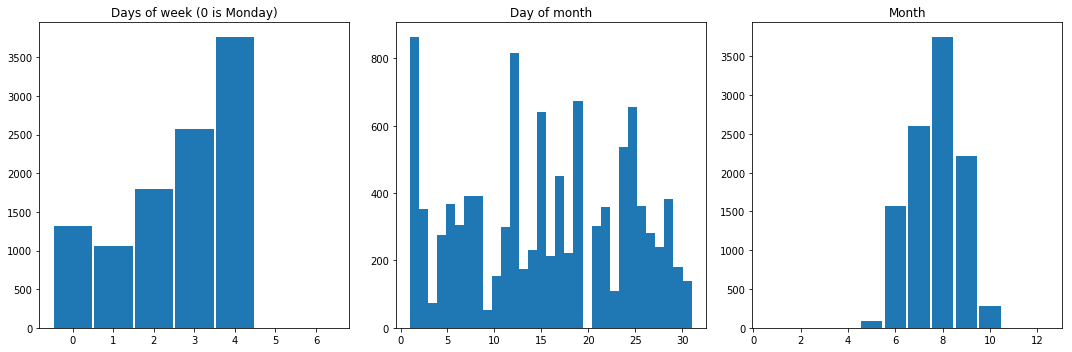

In [45]:
###############################################################################
#   Breakdown of Day of Week, Day of Month, & Month of Year -- Train (all)    #
###############################################################################
f, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

_ = axes[0].hist(train.Date.dt.dayofweek, bins=np.arange(8)-0.5, rwidth=0.95)
axes[0].set_title("Days of week (0 is Monday)")
_ = axes[1].hist(train.Date.dt.day, bins=31)
axes[1].set_title("Day of month")
_ = axes[2].hist(train[train.Date.dt.year < 2018].Date.dt.month, bins=np.arange(1,14)-0.5, rwidth=0.9)
axes[2].set_title("Month")

f.tight_layout()

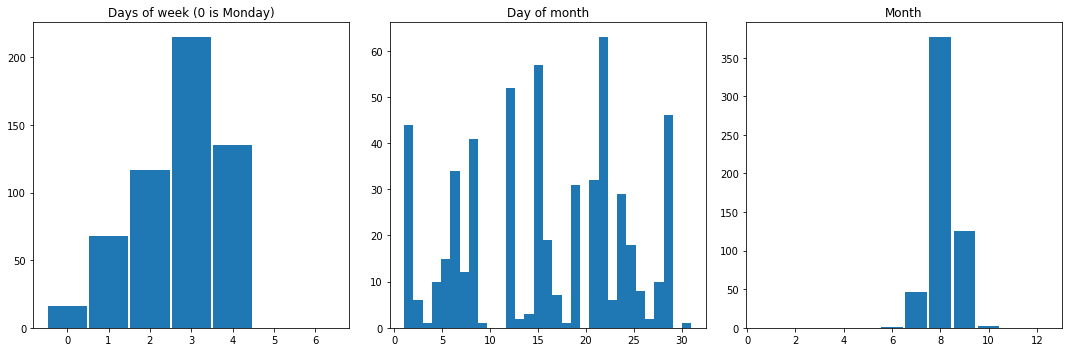

In [46]:
###############################################################################
#   Breakdown of Day of Week, Day of Month, & Month of Year -- Train (yes WNV)    #
###############################################################################
f, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

_ = axes[0].hist(train_WNV.Date.dt.dayofweek, bins=np.arange(8)-0.5, rwidth=0.95)
axes[0].set_title("Days of week (0 is Monday)")
_ = axes[1].hist(train_WNV.Date.dt.day, bins=31)
axes[1].set_title("Day of month")
_ = axes[2].hist(train_WNV[train_WNV.Date.dt.year < 2018].Date.dt.month, bins=np.arange(1,14)-0.5, rwidth=0.9)
axes[2].set_title("Month")

f.tight_layout()

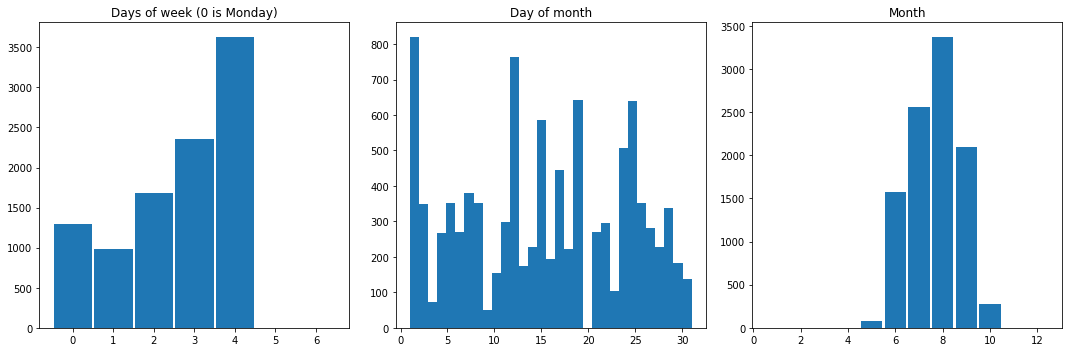

In [47]:
###############################################################################
#   Breakdown of Day of Week, Day of Month, & Month of Year -- Train (no WNV)    #
###############################################################################
train_noWNV = train[train['WnvPresent'] == 0]
f, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

_ = axes[0].hist(train_noWNV.Date.dt.dayofweek, bins=np.arange(8)-0.5, rwidth=0.95)
axes[0].set_title("Days of week (0 is Monday)")
_ = axes[1].hist(train_noWNV.Date.dt.day, bins=31)
axes[1].set_title("Day of month")
_ = axes[2].hist(train_noWNV[train_noWNV.Date.dt.year < 2018].Date.dt.month, bins=np.arange(1,14)-0.5, rwidth=0.9)
axes[2].set_title("Month")

f.tight_layout()

## Test Data Explortaion <a name="testex"></a>

In [48]:
##########################################
##########################################
#           Test Data Exploration
#########################################
##########################################
print(test.dtypes)
test.head()

Id                          int64
Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
dtype: object


,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [49]:
test['Date'] = pd.to_datetime(test['Date'])

In [50]:
#check for missing values
print('Missing values: ')
print(test.isnull().sum()) 

Missing values: 
Id                        0
Date                      0
Address                   0
Species                   0
Block                     0
Street                    0
Trap                      0
AddressNumberAndStreet    0
Latitude                  0
Longitude                 0
AddressAccuracy           0
dtype: int64


In [51]:
test['Species'].value_counts()

CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
CULEX PIPIENS             14521
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
UNSPECIFIED CULEX         14345
CULEX ERRATICUS           14345
Name: Species, dtype: int64

In [52]:
print(len(test['Trap'].unique()))
print(test['Trap'].unique())

149
['T002' 'T007' 'T015' 'T045' 'T046' 'T048' 'T049' 'T050' 'T054' 'T086'
 'T091' 'T094' 'T096' 'T129' 'T143' 'T148' 'T153' 'T159' 'T009' 'T011'
 'T016' 'T019' 'T025' 'T028' 'T031' 'T033' 'T089' 'T090' 'T092' 'T135'
 'T141' 'T142' 'T145' 'T146' 'T147' 'T149' 'T150' 'T151' 'T152' 'T154'
 'T158' 'T162' 'T218' 'T220' 'T001' 'T003' 'T006' 'T008' 'T012' 'T034'
 'T037' 'T040' 'T043' 'T047' 'T051' 'T085' 'T088' 'T161' 'T219' 'T013'
 'T014' 'T018' 'T030' 'T084' 'T144' 'T160' 'T005' 'T017' 'T044' 'T095'
 'T004' 'T035' 'T036' 'T039' 'T060' 'T061' 'T062' 'T065' 'T066' 'T067'
 'T069' 'T070' 'T071' 'T073' 'T074' 'T075' 'T076' 'T077' 'T079' 'T080'
 'T081' 'T082' 'T083' 'T114' 'T155' 'T063' 'T115' 'T138' 'T200' 'T206'
 'T209' 'T212' 'T215' 'T107' 'T128' 'T072' 'T078' 'T097' 'T099' 'T100'
 'T102' 'T103' 'T027' 'T156' 'T157' 'T221' 'T900' 'T903' 'T090A' 'T090B'
 'T090C' 'T200A' 'T128A' 'T200B' 'T218A' 'T218C' 'T218B' 'T222' 'T223'
 'T225' 'T227' 'T224' 'T226' 'T229' 'T230' 'T228' 'T231' 'T232' 'T002A'

In [53]:
test['AddressAccuracy'].value_counts()

8    61973
9    39795
5    13761
3      764
Name: AddressAccuracy, dtype: int64

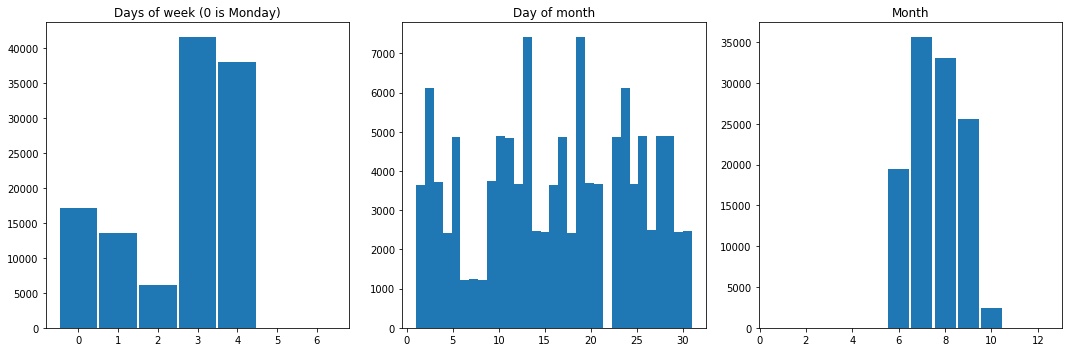

In [54]:
###############################################################################
#   Breakdown of Day of Week, Day of Month, & Month of Year -- Test           #
###############################################################################
f, axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))

_ = axes[0].hist(test.Date.dt.dayofweek, bins=np.arange(8)-0.5, rwidth=0.95)
axes[0].set_title("Days of week (0 is Monday)")
_ = axes[1].hist(test.Date.dt.day, bins=31)
axes[1].set_title("Day of month")
_ = axes[2].hist(test[test.Date.dt.year < 2018].Date.dt.month, bins=np.arange(1,14)-0.5, rwidth=0.9)
axes[2].set_title("Month")

f.tight_layout()

One can note that the test set has no records in the month of May.

There are many more test records than training records (116,293 v. 10506), before any combining of rows.

There are also 13 additional traps in the test set than in the training set (149 v 136, resp.)

# Data Prep <a name="dataprep"></a>

## Spray <a name="sprayprep"></a>

In [55]:
##########################################
##########################################
#           Spray Data Prep
#########################################
##########################################

#need to deal with missing times on 9/7/2011:
# Here I will generate a list of times within that window and then random assign the missing times a time from this list.
begin = 194212 #dt.datetime(2011, 9, 7, 19, 42, 12, 0)
end = 214110 #dt.datetime(2011, 9, 7, 21, 41, 10, 0)
times = []
t2 = ''
t = begin
for i in range(0, 120):
    t = t + 100
    t2 = str(t)
    if int(t2[2]) < 6:
        times.append(t2[:2] + ':' + t2[2:4] + ':' + t2[-2:])
    else:
        t = t + 4000
spray['Time'] = spray['Time'].fillna(pd.Series(np.random.choice(times, size=len(spray.index))))


Ultimately chose not to use the Spray data in my analysis due to the fact that it only had data from 2011 and 2013.

## Weather <a name="wthrprep"></a>

In [155]:
####################################
####################################
#        Weather Data Prep
####################################
####################################

 ### Notes about the Data Prep that needs to be done (comes from the Data Exploration Section above)
 
 Tavg: there are 11 cases of 'M' -- this should be fixed in data prep, all from Station 2

 WetBulb: 4 'M's - 3 from Station 1 & 1 from Station 2 should be able to pulll in wetbulb from other station on that day (days are not the same for the M's

 Heat:  11 M's, all from Station 2
 should be able to pulll in heat from station 1 on that day
 note the same exact case is true for 'Cool', do the same procedure

 Sunrise & Sunset:   all missing from Station 2, Sunset as well
 should be able to pull in time from Station 1
 times are 4 character strings, not integers or timestamps

 Daylight: create! :)

 CodeSum:  delete column

 Depth:  delete column

 Water1:  delete column

 SnowFall:  delete column

 PrecipTotal:  2 from station 2 == M;  318 from a mix of Station 1 & 2 == '  T', some same days.
 could set to 0 for days when both missing and could fill in from other station on days when only 1 station is missing

 StnPressure:  4 M's, different stations, different days.
 can pull in category from other station on that day.

 SeaLevel:  9 M's, different stations, different days
 pull in category from the other station on that day

 AvgSpeed: 3 M's, all station 2
 pull in category from the other station on that day


In [56]:
del wthr['CodeSum'], wthr['Depth'], wthr['Water1'], wthr['SnowFall']

In [57]:
# Sunrise & Sunset
wthr['Sunrise'] = wthr['Sunrise'].replace('-', '')
wthr['Sunset'] = wthr['Sunset'].replace('-', '')

In [58]:
wthr['Sunrise'] = wthr.Sunrise.replace(r'^\s*$', np.nan, regex=True)
wthr['Sunset'] = wthr.Sunset.replace(r'^\s*$', np.nan, regex=True)

In [59]:
# ffill = forward fill -- takes care of filling in the 'missing' values
wthr['Sunrise'] = wthr.groupby(['Date'])['Sunrise'].ffill()
wthr['Sunset'] = wthr.groupby(['Date'])['Sunset'].ffill() 

In [60]:
# Create a Daylight field (ie number of minutes from sunrise to sunset)
rise = wthr.Sunrise.values
sunset = wthr.Sunset.values
wthr['Daylight'] = daylight(rise, sunset)

In [61]:
# Tavg
wthr['Tavg'] = wthr['Tavg'].replace('M', '')
wthr['Tavg'] = wthr.Tavg.replace(r'^\s*$', np.nan, regex=True)

In [62]:
# ffill = forward fill
wthr['Tavg'] = wthr.groupby(['Date'])['Tavg'].ffill()

In [63]:
# WetBulb
wthr['WetBulb'] = wthr['WetBulb'].replace('M', '')
wthr['WetBulb'] = wthr.WetBulb.replace(r'^\s*$', np.nan, regex=True)
wthr['WetBulb'] = wthr['WetBulb'].apply(pd.to_numeric, errors='coerce')
wthr['WetBulb'] = wthr.groupby(['Date'])['WetBulb'].ffill()
wthr['WetBulb'] = wthr.groupby(['Date'])['WetBulb'].bfill()

In [64]:
# Heat & Cool
wthr['Heat'] = wthr['Heat'].replace('M', '')
wthr['Cool'] = wthr['Cool'].replace('M', '')
wthr['Heat'] = wthr.Heat.replace(r'^\s*$', np.nan, regex=True)
wthr['Cool'] = wthr.Cool.replace(r'^\s*$', np.nan, regex=True)
wthr['Heat'] = wthr['Heat'].apply(pd.to_numeric, errors='coerce')
wthr['Cool'] = wthr['Cool'].apply(pd.to_numeric, errors='coerce')
wthr['Heat'] = wthr.groupby(['Date'])['Heat'].ffill()
wthr['Cool'] = wthr.groupby(['Date'])['Cool'].ffill()

In [65]:
# PrecipTotal
wthr['PrecipTotal'] = wthr['PrecipTotal'].replace('M', '')
wthr['PrecipTotal'] = wthr['PrecipTotal'].replace('  T', '')
wthr['PrecipTotal'] = wthr.PrecipTotal.replace(r'^\s*$', np.nan, regex=True)
wthr['PrecipTotal'] = wthr['PrecipTotal'].apply(pd.to_numeric, errors='coerce')
wthr['PrecipTotal'] = wthr.groupby(['Date'])['PrecipTotal'].ffill()

In [66]:
## for some reason the ffill command would not work for the PrecipTotal, so as an alternative I set them all to zero
wthr['PrecipTotal'].fillna(0, inplace=True)

In [67]:
# StnPressure
wthr['StnPressure'] = wthr['StnPressure'].replace('M', '')
wthr['StnPressure'] = wthr.StnPressure.replace(r'^\s*$', np.nan, regex=True)
wthr['StnPressure'] = wthr['StnPressure'].apply(pd.to_numeric, errors='coerce')
wthr['StnPressure'] = wthr.groupby(['Date'])['StnPressure'].ffill()
# StnPressure -- this had to be done b/c 2 of the 4 original M's were from the same day, so pulled in prior day's.
wthr['StnPressure'] = wthr['StnPressure'].ffill()

In [68]:
# SeaLevel
wthr['SeaLevel'] = wthr['SeaLevel'].replace('M', '')
wthr['SeaLevel'] = wthr.SeaLevel.replace(r'^\s*$', np.nan, regex=True)
wthr['SeaLevel'] = wthr['SeaLevel'].apply(pd.to_numeric, errors='coerce')
wthr['SeaLevel'] = wthr.groupby(['Date'])['SeaLevel'].ffill()
wthr['SeaLevel'] = wthr.groupby(['Date'])['SeaLevel'].bfill()

In [69]:
# AvgSpeed
wthr['AvgSpeed'] = wthr['AvgSpeed'].replace('M', '')
wthr['AvgSpeed'] = wthr.AvgSpeed.replace(r'^\s*$', np.nan, regex=True)
wthr['AvgSpeed'] = wthr['AvgSpeed'].apply(pd.to_numeric, errors='coerce')
wthr['AvgSpeed'] = wthr.groupby(['Date'])['AvgSpeed'].ffill()

In [70]:
# Depart
wthr['Depart'] = wthr['Depart'].replace('M', '')
wthr['Depart'] = wthr.Depart.replace(r'^\s*$', np.nan, regex=True)
wthr['Depart'] = wthr['Depart'].apply(pd.to_numeric, errors='coerce')
wthr['Depart'] = wthr.groupby(['Date'])['Depart'].ffill()

In [71]:
del wthr['Sunrise'], wthr['Sunset']

Now that the weather data is cleaned up, we can remove Sunrise and Sunset as the final step before we merge it with the training & test data

In [72]:
wthr[['Tavg','Depart', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']] = wthr[['Tavg','Depart', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'AvgSpeed']].apply(pd.to_numeric)

## Training & Test Data <a name="trainprep"></a>

In [74]:
####################################
####################################
#        TRAINING & TESTING Data Prep
####################################
####################################

# Need to combine Training & Testing to do all the prep. And then will split back up after prep is finished.


# 1. Assign id to Train & combine rows
# 2. Combine Train+Test = df
# 3. do data prep on df
# 4. Separate df back into Train & Test

In [75]:
train['Id'] = train.Date.dt.year.astype(str) + train.Date.dt.month.astype(str) + train.Date.dt.day.astype(str) + train['Species'].astype(str) + train['Trap']
train['NumMosq'] = train.groupby(['Id'])['NumMosquitos'].transform('sum')
train = train.groupby('Id', group_keys=False).apply(lambda x: x.loc[x.NumMosquitos.idxmin()])

In [76]:
train = train.reset_index(drop=True)

Combine train & test data for data prep

In [77]:
df = pd.concat([train, test], axis=0, sort=True)

In [78]:
df.dtypes

Address                           object
AddressAccuracy                    int64
AddressNumberAndStreet            object
Block                              int64
Date                      datetime64[ns]
Id                                object
Latitude                         float64
Longitude                        float64
NumMosq                          float64
NumMosquitos                     float64
Species                           object
Street                            object
Trap                              object
WnvPresent                       float64
dtype: object

In [79]:
df['Station'] = df.apply (lambda row: distance_calc (row),axis=1)

In [80]:
df = pd.merge(df, wthr,  how='left', left_on=['Date','Station'], right_on = ['Date','Station'])

In [81]:
df.dtypes

Address                           object
AddressAccuracy                    int64
AddressNumberAndStreet            object
Block                              int64
Date                      datetime64[ns]
Id                                object
Latitude                         float64
Longitude                        float64
NumMosq                          float64
NumMosquitos                     float64
Species                           object
Street                            object
Trap                              object
WnvPresent                       float64
Station                            int64
Tmax                               int64
Tmin                               int64
Tavg                               int64
Depart                           float64
DewPoint                           int64
WetBulb                          float64
Heat                             float64
Cool                             float64
PrecipTotal                      float64
StnPressure     

In [82]:
df.describe()

,AddressAccuracy,Block,Latitude,Longitude,NumMosq,NumMosquitos,WnvPresent,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Daylight
count,124768.000000,124768.000000,124768.000000,124768.000000,8475.000000,8475.000000,8475.000000,124768.000000,124768.00000,124768.000000,124768.000000,124768.000000,124768.000000,124768.000000,124768.000000,124768.000000,124768.000000,124768.000000,124768.000000,124768.000000,124768.000000,124768.000000,124768.000000
mean,7.953466,40.982904,41.849065,-87.693735,15.933805,7.580649,0.042242,1.696525,81.29865,62.942076,72.365575,1.796294,57.701750,63.517272,0.516695,7.882269,0.152571,29.310656,29.973845,6.208919,18.296623,7.995395,842.124936
std,1.257535,24.820672,0.106600,0.080932,75.084707,9.757211,0.201152,0.459760,7.51232,6.353919,6.445514,5.442276,7.238782,5.748837,1.715302,5.518774,0.414782,0.122172,0.123528,2.878780,10.033411,2.528668,64.061709
min,3.000000,10.000000,41.644612,-87.930995,1.000000,1.000000,0.000000,1.000000,56.00000,41.000000,50.000000,-12.000000,38.000000,46.000000,0.000000,0.000000,0.000000,28.890000,29.590000,0.100000,1.000000,1.900000,683.000000
25%,8.000000,17.000000,41.753411,-87.750938,2.000000,1.000000,0.000000,1.000000,76.00000,58.000000,68.000000,-2.000000,52.000000,59.000000,0.000000,3.000000,0.000000,29.230000,29.880000,4.100000,9.000000,6.100000,793.000000
50%,8.000000,38.000000,41.862292,-87.694991,4.000000,3.000000,0.000000,2.000000,82.00000,64.000000,73.000000,2.000000,59.000000,64.000000,0.000000,8.000000,0.000000,29.310000,29.980000,6.100000,19.000000,7.900000,858.000000
75%,9.000000,61.000000,41.949830,-87.648064,11.000000,9.000000,0.000000,2.000000,87.00000,69.000000,77.000000,6.000000,63.000000,68.000000,0.000000,12.000000,0.060000,29.390000,30.060000,7.800000,26.000000,9.500000,901.000000
max,9.000000,98.000000,42.017430,-87.531635,2532.000000,50.000000,1.000000,2.000000,97.00000,79.000000,87.000000,18.000000,73.000000,76.000000,15.000000,22.000000,3.970000,29.650000,30.330000,16.600000,36.000000,17.300000,914.000000


In [83]:
df['Date_min4'] = df['Date'] - timedelta(days=4)

In [84]:
df = pd.merge(df, wthr,  how='left', left_on=['Date_min4','Station'], right_on = ['Date','Station'])

In [85]:
del df['Address'], df['AddressAccuracy'], df['AddressNumberAndStreet'], df['Street'], df['Date_y']

In [86]:
df.rename(columns={'Date_x': 'Date', 'Tmax_x': 'Tmax_0', 
                  'Tmin_x': 'Tmin_0', 'Tavg_x': 'Tavg_0',
                  'Depart_x': 'Depart_0', 'DewPoint_x':'DewPoint_0',
                  'WetBulb_x':'WetBulb_0', 'Heat_x':'Heat_0', 'Cool_x':'Cool_0',
                  'PrecipTotal_x':'PrecipTotal_0', 'StnPressure_x':'StnPressure_0',
                  'SeaLevel_x':'SeaLevel_0', 'ResultSpeed_x':'ResultSpeed_0',
                   'ResultDir_x':'ResultDir_0',
                  'AvgSpeed_x':'AvgSpeed_0', 'Daylight_x':'Daylight_0',
                  'Tmax_y': 'Tmax_4', 
                  'Tmin_y': 'Tmin_4', 'Tavg_y': 'Tavg_4',
                  'Depart_y': 'Depart_4', 'DewPoint_y':'DewPoint_4',
                  'WetBulb_y':'WetBulb_4', 'Heat_y':'Heat_4', 'Cool_y':'Cool_4',
                  'PrecipTotal_y':'PrecipTotal_4', 'StnPressure_y':'StnPressure_4',
                  'SeaLevel_y':'SeaLevel_4', 'ResultSpeed_y':'ResultSpeed_4',
                   'ResultDir_y':'ResultDir_4',
                  'AvgSpeed_y':'AvgSpeed_4', 'Daylight_y':'Daylight_4'}, inplace=True)

In [87]:
## Create dummy variables for Categorical fields

#dummy variables for month
df['Month_May'] = np.where(df.Date.dt.month == 5, 1, 0)
df['Month_June'] = np.where(df.Date.dt.month == 6, 1, 0)
df['Month_July'] = np.where(df.Date.dt.month == 7, 1, 0)
df['Month_Aug'] = np.where(df.Date.dt.month == 8, 1, 0)
df['Month_Sept'] = np.where(df.Date.dt.month == 9, 1, 0)
# Note, October will be all zeros

# dummy variables for year
df['Yr_2007'] = np.where(df.Date.dt.year == 2007, 1, 0)
df['Yr_2008'] = np.where(df.Date.dt.year == 2008, 1, 0)
df['Yr_2009'] = np.where(df.Date.dt.year == 2009, 1, 0)
df['Yr_2010'] = np.where(df.Date.dt.year == 2010, 1, 0)
df['Yr_2011'] = np.where(df.Date.dt.year == 2011, 1, 0)
df['Yr_2012'] = np.where(df.Date.dt.year == 2012, 1, 0)
df['Yr_2013'] = np.where(df.Date.dt.year == 2013, 1, 0)
# df['Yr_2014'] = np.where(df.year == 2014, 1, 0) <-- ALL ZEROS

#dummy variables for week of month
df['Week1'] = np.where((df.Date.dt.day >=1) & (df.Date.dt.day <=7), 1, 0)
df['Week2'] = np.where((df.Date.dt.day >=8) & (df.Date.dt.day <=14), 1, 0)
df['Week3'] = np.where((df.Date.dt.day >=15) & (df.Date.dt.day <=21), 1, 0)
df['Week4'] = np.where((df.Date.dt.day >=22) & (df.Date.dt.day <=28), 1, 0)
# Note, Week5 will be all zeros

In [88]:
# dummy variables for Trap
trap = list(df['Trap'].unique())
trap = trap[:-1]
for i in range(0, len(trap)):
    title = 'Trap_' + str(trap[i])
    df[title] = np.where(df['Trap'] == trap[i], 1, 0)

In [89]:
# dummy variables for Species
species = df.Species.unique()
num = range(1, len(species)+1)
species_dict = {}
species_num = zip(species, num)
for species, num in species_num:
    species_dict[species] = num
df['Species_n'] = df['Species'].map(species_dict)

In [90]:
species_dict

{'CULEX PIPIENS/RESTUANS': 1,
 'CULEX PIPIENS': 2,
 'CULEX RESTUANS': 3,
 'CULEX SALINARIUS': 4,
 'CULEX TERRITANS': 5,
 'CULEX TARSALIS': 6,
 'CULEX ERRATICUS': 7,
 'UNSPECIFIED CULEX': 8}

In [91]:
# dummy variables for Mosq species
df['Mosq_CPR'] = np.where(df.Species_n == 1, 1, 0)
df['Mosq_CR'] = np.where(df.Species_n == 2, 1, 0)
df['Mosq_CP'] = np.where(df.Species_n == 3, 1, 0)
df['Mosq_CS'] = np.where(df.Species_n == 4, 1, 0)
df['Mosq_CT1'] = np.where(df.Species_n == 5, 1, 0)
df['Mosq_CT2'] = np.where(df.Species_n == 6, 1, 0)
df['Mosq_CE'] = np.where(df.Species_n == 7, 1, 0)
# Mosq species UNSPECIFIED CULEX  is ALL ZEROS

In [92]:
testcorr = df.copy()
del testcorr['Date'], testcorr['Id'], testcorr['NumMosquitos'], testcorr['Species'], testcorr['Trap'], testcorr['WnvPresent'], testcorr['Station'], testcorr['Date_min4'], testcorr['Species_n']
testcorr = df.iloc[:,3:24] 
list(testcorr)

['Latitude',
 'Longitude',
 'NumMosq',
 'NumMosquitos',
 'Species',
 'Trap',
 'WnvPresent',
 'Station',
 'Tmax_0',
 'Tmin_0',
 'Tavg_0',
 'Depart_0',
 'DewPoint_0',
 'WetBulb_0',
 'Heat_0',
 'Cool_0',
 'PrecipTotal_0',
 'StnPressure_0',
 'SeaLevel_0',
 'ResultSpeed_0',
 'ResultDir_0']

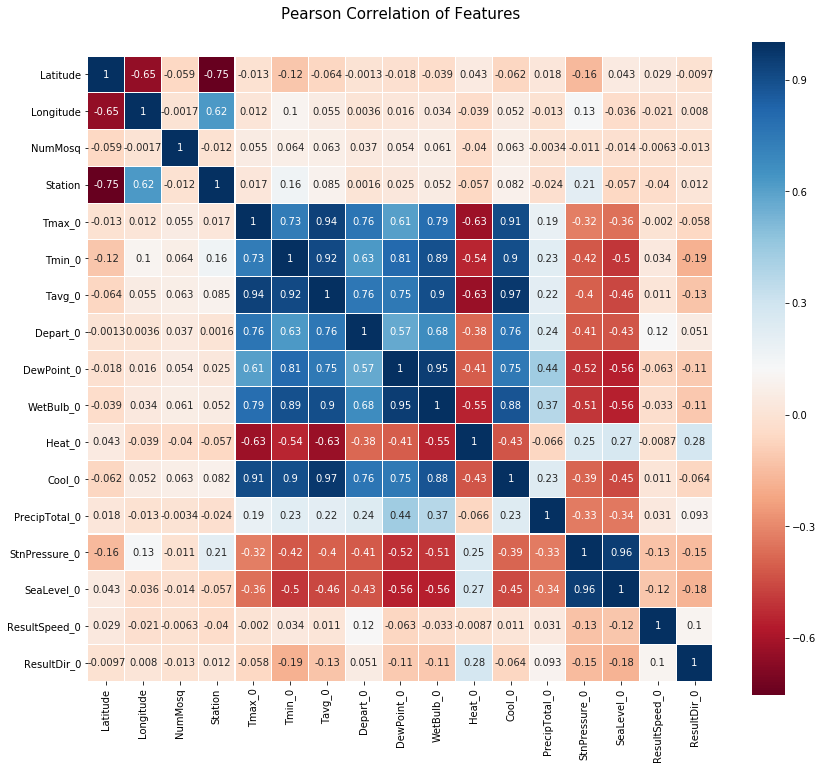

In [93]:
del testcorr['Trap'], testcorr['Species'], testcorr['NumMosquitos'], testcorr['WnvPresent']
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(testcorr.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

In [94]:
# split the data back into train and test.
train = df[df['WnvPresent'] >= 0]
test = df[df['WnvPresent'].isna()]

In [95]:
train.head()

,Block,Date,Id,Latitude,Longitude,NumMosq,NumMosquitos,Species,Trap,WnvPresent,Station,Tmax_0,Tmin_0,Tavg_0,Depart_0,DewPoint_0,WetBulb_0,Heat_0,Cool_0,PrecipTotal_0,StnPressure_0,SeaLevel_0,ResultSpeed_0,ResultDir_0,AvgSpeed_0,Daylight_0,Date_min4,Tmax_4,Tmin_4,Tavg_4,Depart_4,DewPoint_4,WetBulb_4,Heat_4,Cool_4,PrecipTotal_4,StnPressure_4,SeaLevel_4,ResultSpeed_4,ResultDir_4,AvgSpeed_4,Daylight_4,Month_May,Month_June,Month_July,Month_Aug,Month_Sept,Yr_2007,Yr_2008,Yr_2009,Yr_2010,Yr_2011,Yr_2012,Yr_2013,Week1,Week2,Week3,Week4,Trap_T002,Trap_T003,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T019,Trap_T025,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T073,Trap_T074,Trap_T075,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T096,Trap_T100,Trap_T102,Trap_T103,Trap_T114,Trap_T129,Trap_T135,Trap_T141,Trap_T143,Trap_T144,Trap_T146,Trap_T147,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T158,Trap_T160,Trap_T161,Trap_T162,Trap_T219,Trap_T220,Trap_T001,Trap_T004,Trap_T043,Trap_T044,Trap_T060,Trap_T077,Trap_T089,Trap_T095,Trap_T097,Trap_T145,Trap_T157,Trap_T218,Trap_T027,Trap_T107,Trap_T115,Trap_T128,Trap_T138,Trap_T200,Trap_T209,Trap_T212,Trap_T215,Trap_T221,Trap_T206,Trap_T148,Trap_T159,Trap_T040,Trap_T142,Trap_T018,Trap_T009,Trap_T083,Trap_T076,Trap_T072,Trap_T099,Trap_T078,Trap_T222,Trap_T223,Trap_T225,Trap_T228,Trap_T229,Trap_T900,Trap_T903,Trap_T230,Trap_T227,Trap_T226,Trap_T224,Trap_T232,Trap_T231,Trap_T235,Trap_T233,Trap_T236,Trap_T237,Trap_T238,Trap_T094B,Trap_T054C,Trap_T090A,Trap_T090B,Trap_T090C,Trap_T200A,Trap_T128A,Trap_T200B,Trap_T218A,Trap_T218C,Trap_T218B,Trap_T002A,Trap_T002B,Trap_T234,Species_n,Mosq_CPR,Mosq_CR,Mosq_CP,Mosq_CS,Mosq_CT1,Mosq_CT2,Mosq_CE
0,41,2007-10-04,2007104CULEX PIPIENS/RESTUANST002,41.954690,-87.800991,29.0,29.0,CULEX PIPIENS/RESTUANS,T002,0.0,1,82,51,67,10.0,56,61.0,0.0,2.0,0.0,29.34,30.04,3.9,17,4.6,697.0,2007-09-30,83,59,71,12.0,49,59.0,0.0,6.0,0.14,29.36,30.1,14.4,19,14.6,708.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
1,46,2007-10-04,2007104CULEX PIPIENS/RESTUANST003,41.964242,-87.757639,10.0,10.0,CULEX PIPIENS/RESTUANS,T003,0.0,1,82,51,67,10.0,56,61.0,0.0,2.0,0.0,29.34,30.04,3.9,17,4.6,697.0,2007-09-30,83,59,71,12.0,49,59.0,0.0,6.0,0.14,29.36,30.1,14.4,19,14.6,708.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
2,60,2007-10-04,2007104CULEX PIPIENS/RESTUANST005,41.942114,-87.776385,2.0,2.0,CULEX PIPIENS/RESTUANS,T005,0.0,1,82,51,67,10.0,56,61.0,0.0,2.0,0.0,29.34,30.04,3.9,17,4.6,697.0,2007-09-30,83,59,71,12.0,49,59.0,0.0,6.0,0.14,29.36,30.1,14.4,19,14.6,708.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0
3,60,2007-10-04,2007104CULEX PIPIENS/RESTUANST006,41.990284,-87.797127,10.0,10.0,CULEX PIPIENS/RESTUANS,T006,0.0

In [96]:
# check to make sure data is okay
train[train.isnull().any(axis=1)]

,Block,Date,Id,Latitude,Longitude,NumMosq,NumMosquitos,Species,Trap,WnvPresent,Station,Tmax_0,Tmin_0,Tavg_0,Depart_0,DewPoint_0,WetBulb_0,Heat_0,Cool_0,PrecipTotal_0,StnPressure_0,SeaLevel_0,ResultSpeed_0,ResultDir_0,AvgSpeed_0,Daylight_0,Date_min4,Tmax_4,Tmin_4,Tavg_4,Depart_4,DewPoint_4,WetBulb_4,Heat_4,Cool_4,PrecipTotal_4,StnPressure_4,SeaLevel_4,ResultSpeed_4,ResultDir_4,AvgSpeed_4,Daylight_4,Month_May,Month_June,Month_July,Month_Aug,Month_Sept,Yr_2007,Yr_2008,Yr_2009,Yr_2010,Yr_2011,Yr_2012,Yr_2013,Week1,Week2,Week3,Week4,Trap_T002,Trap_T003,Trap_T005,Trap_T006,Trap_T007,Trap_T008,Trap_T011,Trap_T012,Trap_T013,Trap_T014,Trap_T015,Trap_T016,Trap_T017,Trap_T019,Trap_T025,Trap_T028,Trap_T030,Trap_T031,Trap_T033,Trap_T034,Trap_T035,Trap_T036,Trap_T037,Trap_T039,Trap_T045,Trap_T046,Trap_T047,Trap_T048,Trap_T049,Trap_T050,Trap_T051,Trap_T054,Trap_T061,Trap_T062,Trap_T063,Trap_T065,Trap_T066,Trap_T067,Trap_T069,Trap_T070,Trap_T071,Trap_T073,Trap_T074,Trap_T075,Trap_T079,Trap_T080,Trap_T081,Trap_T082,Trap_T084,Trap_T085,Trap_T086,Trap_T088,Trap_T090,Trap_T091,Trap_T092,Trap_T094,Trap_T096,Trap_T100,Trap_T102,Trap_T103,Trap_T114,Trap_T129,Trap_T135,Trap_T141,Trap_T143,Trap_T144,Trap_T146,Trap_T147,Trap_T149,Trap_T150,Trap_T151,Trap_T152,Trap_T153,Trap_T154,Trap_T155,Trap_T156,Trap_T158,Trap_T160,Trap_T161,Trap_T162,Trap_T219,Trap_T220,Trap_T001,Trap_T004,Trap_T043,Trap_T044,Trap_T060,Trap_T077,Trap_T089,Trap_T095,Trap_T097,Trap_T145,Trap_T157,Trap_T218,Trap_T027,Trap_T107,Trap_T115,Trap_T128,Trap_T138,Trap_T200,Trap_T209,Trap_T212,Trap_T215,Trap_T221,Trap_T206,Trap_T148,Trap_T159,Trap_T040,Trap_T142,Trap_T018,Trap_T009,Trap_T083,Trap_T076,Trap_T072,Trap_T099,Trap_T078,Trap_T222,Trap_T223,Trap_T225,Trap_T228,Trap_T229,Trap_T900,Trap_T903,Trap_T230,Trap_T227,Trap_T226,Trap_T224,Trap_T232,Trap_T231,Trap_T235,Trap_T233,Trap_T236,Trap_T237,Trap_T238,Trap_T094B,Trap_T054C,Trap_T090A,Trap_T090B,Trap_T090C,Trap_T200A,Trap_T128A,Trap_T200B,Trap_T218A,Trap_T218C,Trap_T218B,Trap_T002A,Trap_T002B,Trap_T234,Species_n,Mosq_CPR,Mosq_CR,Mosq_CP,Mosq_CS,Mosq_CT1,Mosq_CT2,Mosq_CE


In [97]:
# Remove columns that will not be features in the Logistic Regression:
test_ids = test[['Id', 'WnvPresent']].copy()
del train['Id'], train['Date'], train['Trap'], train['Station'], train['NumMosquitos'], train['Species'], train['Date_min4'], train['Species_n'], train['NumMosq']
del test['Id'], test['Date'], test['Trap'], test['Station'], test['NumMosquitos'], test['Species'], test['Date_min4'], test['Species_n'], test['NumMosq']

In [98]:
testcorr = train.copy()
testcorr = testcorr.iloc[:,0:20]

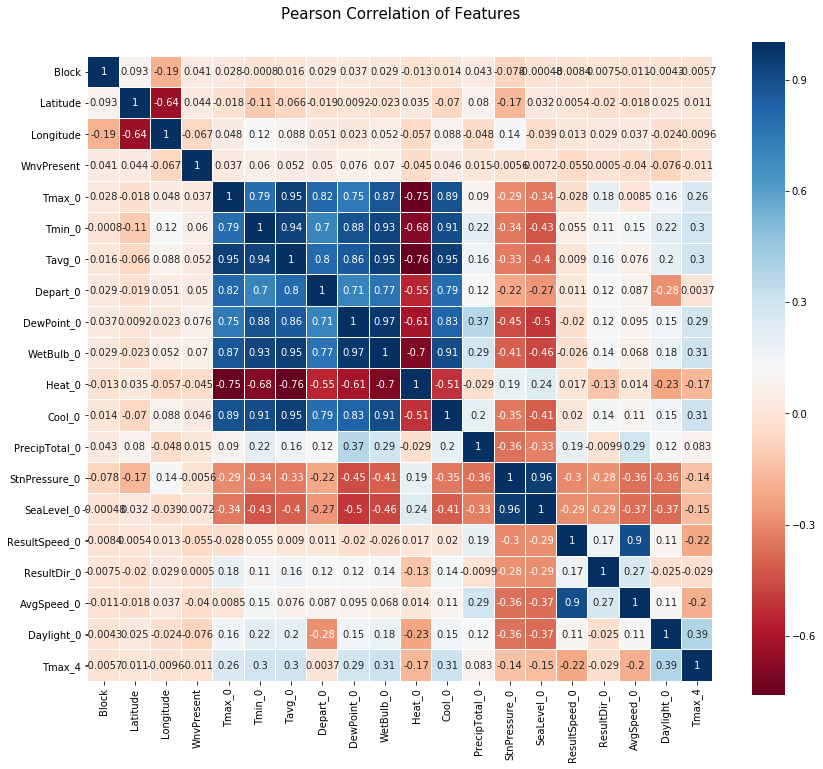

In [99]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(testcorr.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

In [100]:
testcorr2 = train.copy()
testcorr2 = testcorr2.iloc[:,0:40]

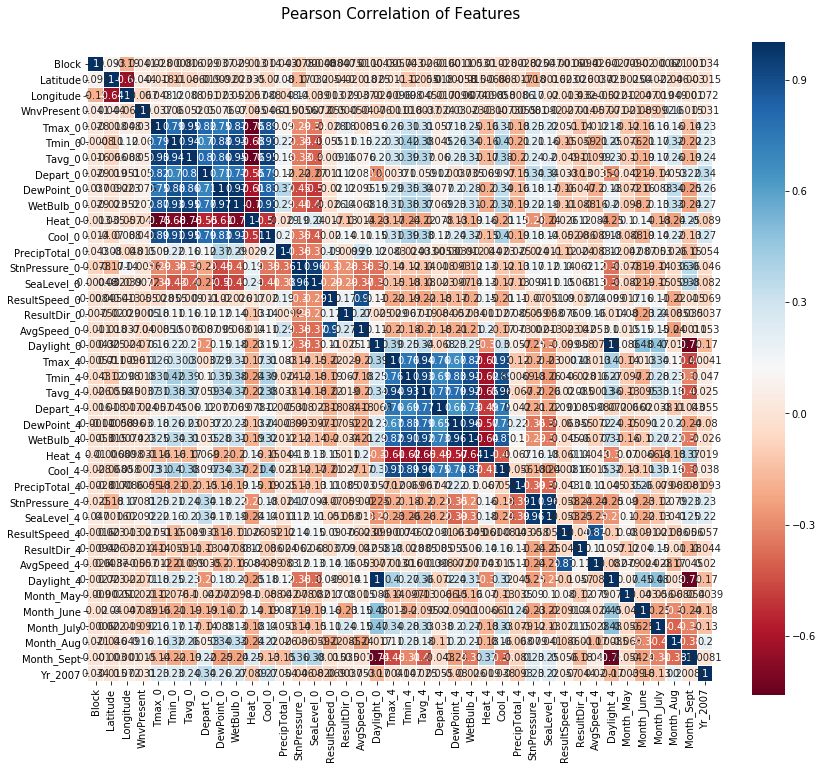

In [101]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(testcorr2.astype(float).corr(),linewidths=0.1,vmax=1.0,
            square=True, cmap=colormap, linecolor='white', annot=True)

# Analysis: Building Logistic Regression Models <a name="analysis"></a>

You can only use past data to predict future data. Thus the following will happen:

1. To predict 2008:

    a. Use 2007 as training for a model that will later predict 2008
    
2. To predict 2010:

    a. Use 2009 as training for a model that might later predict 2010
    
    b. Use both 2007 & 2009 as training for a model that might later predict 2010
    
    c. take the better of (a) and (b)
    
3. To predict 2012:

    a. Use 2011 as training for a model that might later predict 2012
    
    b. Use 2007, 2009, and 2011 as training for a model that might later predict 2012
    
    c. take the better of (a) and (b)
    
3. To predict 2014:

    a. Use 2013 as training for a model that might later predict 2014
    
    b. Use 2007, 2009, 2011, and 2013 (ie all training data) as training for a model that might later predict 2014
    
    c. take the better of (a) and (b)

Since there is a huge class imbalance, I will be doing random oversampling of the smaller class (ie classs 1, the positive cases of WNV)

## Train 2007 <a name="train2007"></a>

In [107]:
####################################
####################################
#         2007 --> 2008
####################################
####################################

train_2007 = train[train['Yr_2007'] == 1]

y_2007 = train_2007['WnvPresent']
X_2007 = train_2007.drop('WnvPresent', axis=1)

X_2007_train, X_2007_test, y_2007_train, y_2007_test = train_test_split(X_2007, y_2007, test_size=0.3, random_state=0)
logreg = LogisticRegression(random_state=42, class_weight='balanced')
parameters={'C':[0.001, 0.01, 0.1, 1, 10 ], 'penalty':['l1', 'l2']}
gs_logreg = GridSearchCV(logreg, parameters, cv=5,n_jobs=-1,return_train_score=True,scoring='f1')
gs_logreg.fit(X_2007_train, y_2007_train)

#this cell was also accidentally run after the fact - can ignore error msg.

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [108]:
gs_logreg.cv_results_

{'mean_fit_time': array([ 0.13074226,  0.0316123 ,  2.31549678,  0.04969044,  4.03862648,
         0.06303558, 10.05980921,  0.10792627, 13.03470898,  0.17567072]),
 'std_fit_time': array([2.34241145e-02, 3.77459618e-03, 2.93421922e-01, 9.95676227e-03,
        5.97706003e-01, 1.34958284e-03, 3.75100234e+00, 5.88969397e-03,
        2.94526339e+00, 2.01008976e-02]),
 'mean_score_time': array([0.00527143, 0.00227785, 0.00181241, 0.00458155, 0.00176229,
        0.00275817, 0.00203409, 0.00186553, 0.00161638, 0.0023396 ]),
 'std_score_time': array([2.37790832e-03, 5.77998039e-04, 8.38259381e-05, 4.28381230e-03,
        6.30267259e-05, 1.53023279e-03, 3.14619910e-04, 3.73767340e-05,
        3.49558865e-04, 7.81617108e-04]),
 'param_C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1, 1, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_ar

In [109]:
gs_logreg.best_estimator_

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [110]:
logreg_2007 = LogisticRegression(C=1, class_weight='balanced', penalty='l2', random_state=42, solver='liblinear')
logreg_2007.fit(X_2007_train, y_2007_train)
y_2007_pred = logreg_2007.predict(X_2007_test)
print('Accuracy of logistic regression classifier on test set for 2007: {:.2f}'.format(logreg_2007.score(X_2007_test, y_2007_test)))

Accuracy of logistic regression classifier on test set for 2007: 0.79


[[629 163]
 [ 14  27]]


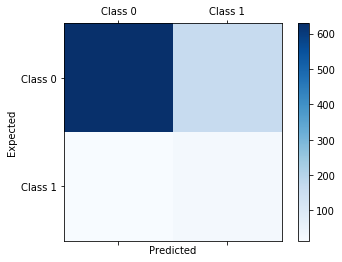

In [111]:
####################################
#        Confusion Matrix
####################################
confusion_matrix_2007 = confusion_matrix(y_2007_test, y_2007_pred)
print(confusion_matrix_2007)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix_2007, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [112]:
####################################
#        Classification Report
####################################
print(classification_report(y_2007_test, y_2007_pred))

             precision    recall  f1-score   support

        0.0       0.98      0.79      0.88       792
        1.0       0.14      0.66      0.23        41

avg / total       0.94      0.79      0.85       833



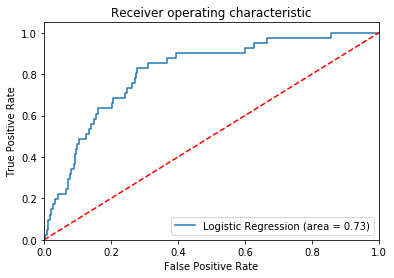

0.7263642522788865

In [113]:
####################################
#        ROC Curve
####################################
logit_roc_auc_2007 = roc_auc_score(y_2007_test, logreg_2007.predict(X_2007_test))
fpr_2007, tpr_2007, thresholds_2007 = roc_curve(y_2007_test, logreg_2007.predict_proba(X_2007_test)[:,1])
plt.figure()
plt.plot(fpr_2007, tpr_2007, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_2007)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

roc_auc_score(y_2007_test, logreg_2007.predict(X_2007_test))

In [114]:
####################################
####################################
#         2009 --> 2010
####################################
####################################
                                      
train_2009 = train[train['Yr_2009'] == 1]
y_2009 = train_2009['WnvPresent']
X_2009 = train_2009.drop('WnvPresent', axis=1)
X_2009_train, X_2009_test, y_2009_train, y_2009_test = train_test_split(X_2009, y_2009, test_size=0.3, random_state=0)
logreg = LogisticRegression(random_state=42, class_weight='balanced')
parameters={'C':[0.001, 0.01, 0.1, 1], 'penalty':['l1', 'l2']}
gs_logreg = GridSearchCV(logreg, parameters, cv=5,n_jobs=-1,return_train_score=True,scoring='f1')
gs_logreg.fit(X_2009_train, y_2009_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [115]:
gs_logreg.cv_results_

{'mean_fit_time': array([0.06818509, 0.01789718, 1.5723701 , 0.02294521, 2.36482339,
        0.03282332, 1.68010182, 0.03632021]),
 'std_fit_time': array([0.01575887, 0.00091207, 0.35921625, 0.00132949, 0.65508942,
        0.00274763, 0.19777542, 0.00499878]),
 'mean_score_time': array([0.00291905, 0.00207515, 0.00293794, 0.00165119, 0.00160327,
        0.00159044, 0.00136347, 0.00141134]),
 'std_score_time': array([7.79529597e-04, 2.90485479e-04, 2.74897774e-03, 1.14751395e-04,
        3.87705852e-05, 1.22652991e-04, 2.78328971e-04, 2.01157506e-04]),
 'param_C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1, 1],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001,

In [116]:
gs_logreg.best_estimator_

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [117]:
logreg_2009 = LogisticRegression(C=0.001, class_weight='balanced', penalty='l2', random_state=42, solver='liblinear')
logreg_2009.fit(X_2009_train, y_2009_train)
y_2009_pred = logreg_2009.predict(X_2009_test)
print('Accuracy of logistic regression classifier on test set for 2009: {:.2f}'.format(logreg_2009.score(X_2009_test, y_2009_test)))

Accuracy of logistic regression classifier on test set for 2009: 0.79


[[448 122]
 [  0   5]]


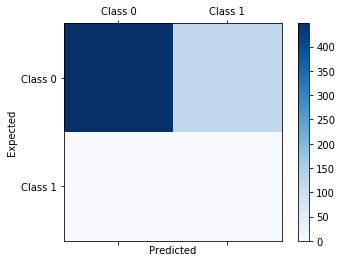

In [118]:
####################################
#        Confusion Matrix
####################################
#from sklearn.metrics import confusion_matrix
confusion_matrix_2009 = confusion_matrix(y_2009_test, y_2009_pred)
print(confusion_matrix_2009)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix_2009, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [119]:
####################################
#        Classification Report
####################################
print(classification_report(y_2009_test, y_2009_pred))

             precision    recall  f1-score   support

        0.0       1.00      0.79      0.88       570
        1.0       0.04      1.00      0.08         5

avg / total       0.99      0.79      0.87       575



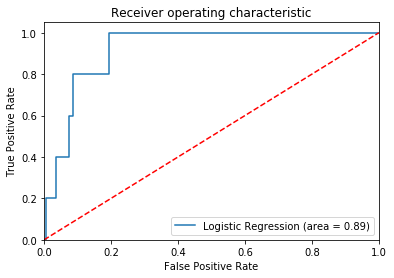

0.8929824561403509

In [120]:
####################################
#        ROC Curve
####################################
logit_roc_auc_2009 = roc_auc_score(y_2009_test, logreg_2009.predict(X_2009_test))
fpr_2009, tpr_2009, thresholds_2009 = roc_curve(y_2009_test, logreg_2009.predict_proba(X_2009_test)[:,1])
plt.figure()
plt.plot(fpr_2009, tpr_2009, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_2009)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

roc_auc_score(y_2009_test, logreg_2009.predict(X_2009_test))

In [121]:
####################################
####################################
#         07 + 09 --> 2010
####################################
####################################
train_0709 = train[(train['Yr_2007'] == 1) | (train['Yr_2009'] == 1)]
y_0709 = train_0709['WnvPresent']
X_0709 = train_0709.drop('WnvPresent', axis=1)
X_0709_train, X_0709_test, y_0709_train, y_0709_test = train_test_split(X_0709, y_0709, test_size=0.3, random_state=0)
logreg = LogisticRegression(random_state=42, class_weight='balanced')
parameters={'C':[0.001, 0.01, 0.1, 1], 'penalty':['l1', 'l2']}
gs_logreg = GridSearchCV(logreg, parameters, cv=5,n_jobs=-1,return_train_score=True,scoring='f1')
gs_logreg.fit(X_0709_train, y_0709_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [122]:
gs_logreg.cv_results_

{'mean_fit_time': array([ 0.41530323,  0.06713963,  6.83748474,  0.07410321, 10.17068453,
         0.15720553, 18.492454  ,  0.30893197]),
 'std_fit_time': array([1.06485835e-01, 7.13318560e-03, 1.96306910e+00, 4.88542482e-03,
        2.98647307e+00, 4.36017916e-03, 4.65321310e+00, 1.38282715e-02]),
 'mean_score_time': array([0.00846276, 0.00460548, 0.00258269, 0.00251579, 0.00248342,
        0.00232296, 0.00205784, 0.00257211]),
 'std_score_time': array([0.00464017, 0.00340174, 0.00034458, 0.00038495, 0.00013461,
        0.00013849, 0.00051455, 0.00012378]),
 'param_C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1, 1],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C'

In [123]:
gs_logreg.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [124]:
logreg_0709 = LogisticRegression(C=1, class_weight='balanced', penalty='l2', random_state=42, solver='liblinear')
logreg_0709.fit(X_0709_train, y_0709_train)
y_0709_pred = logreg_0709.predict(X_0709_test)
print('Accuracy of logistic regression classifier on test set for 2007 & 2009: {:.2f}'.format(logreg_0709.score(X_0709_test, y_0709_test)))

Accuracy of logistic regression classifier on test set for 2007 & 2009: 0.84


[[1156  207]
 [  14   30]]


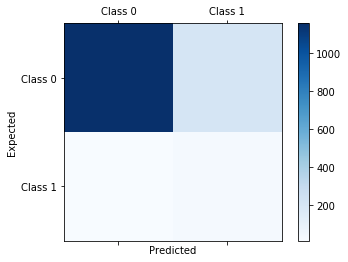

In [125]:
####################################
#        Confusion Matrix
####################################
confusion_matrix_0709 = confusion_matrix(y_0709_test, y_0709_pred)
print(confusion_matrix_0709)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix_0709, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [126]:
####################################
#        Classification Report
####################################
print(classification_report(y_0709_test, y_0709_pred))

             precision    recall  f1-score   support

        0.0       0.99      0.85      0.91      1363
        1.0       0.13      0.68      0.21        44

avg / total       0.96      0.84      0.89      1407



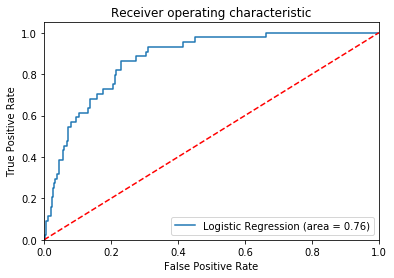

0.7649736543720402

In [127]:
####################################
#        ROC Curve
####################################
logit_roc_auc_0709 = roc_auc_score(y_0709_test, logreg_0709.predict(X_0709_test))
fpr_0709, tpr_0709, thresholds_0709 = roc_curve(y_0709_test, logreg_0709.predict_proba(X_0709_test)[:,1])
plt.figure()
plt.plot(fpr_0709, tpr_0709, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_0709)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

roc_auc_score(y_0709_test, logreg_0709.predict(X_0709_test))

In [128]:
####################################
####################################
#         2011 --> 2012
####################################
####################################
                                      
train_2011 = train[train['Yr_2011'] == 1]
y_2011 = train_2011['WnvPresent']
X_2011 = train_2011.drop('WnvPresent', axis=1)
X_2011_train, X_2011_test, y_2011_train, y_2011_test = train_test_split(X_2011, y_2011, test_size=0.3, random_state=0)
logreg = LogisticRegression(random_state=42, class_weight='balanced')
parameters={'C':[0.001, 0.01, 0.1, 1], 'penalty':['l1', 'l2']}
gs_logreg = GridSearchCV(logreg, parameters, cv=5,n_jobs=-1,return_train_score=True,scoring='f1')
gs_logreg.fit(X_2011_train, y_2011_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [129]:
gs_logreg.cv_results_

{'mean_fit_time': array([0.04270344, 0.01785645, 0.95192471, 0.02562351, 1.91561704,
        0.04784579, 3.26119862, 0.05786319]),
 'std_fit_time': array([0.00769019, 0.00205365, 0.21713819, 0.00437464, 0.92888654,
        0.00517998, 0.83869985, 0.01551954]),
 'mean_score_time': array([0.00335002, 0.00187855, 0.0017796 , 0.00184112, 0.00180874,
        0.00238957, 0.0011663 , 0.00144444]),
 'std_score_time': array([8.79814268e-04, 1.56686499e-04, 4.08117689e-04, 7.57441791e-04,
        6.90081605e-04, 1.45397592e-03, 7.33848204e-05, 2.80795738e-04]),
 'param_C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1, 1],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001,

In [130]:
gs_logreg.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [131]:
logreg_2011 = LogisticRegression(C=1, class_weight='balanced', penalty='l2', random_state=42, solver='liblinear')
logreg_2011.fit(X_2011_train, y_2011_train)
y_2011_pred = logreg_2011.predict(X_2011_test)
print('Accuracy of logistic regression classifier on test set for 2011: {:.2f}'.format(logreg_2011.score(X_2011_test, y_2011_test)))

Accuracy of logistic regression classifier on test set for 2011: 0.92


[[486  36]
 [  6   4]]


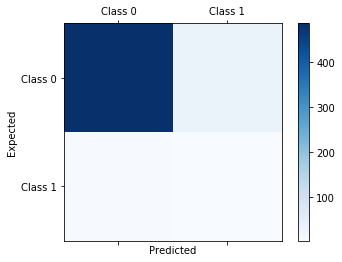

In [132]:
####################################
#        Confusion Matrix
####################################
#from sklearn.metrics import confusion_matrix
confusion_matrix_2011 = confusion_matrix(y_2011_test, y_2011_pred)
print(confusion_matrix_2011)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix_2011, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [133]:
####################################
#        Classification Report
####################################
print(classification_report(y_2011_test, y_2011_pred))

             precision    recall  f1-score   support

        0.0       0.99      0.93      0.96       522
        1.0       0.10      0.40      0.16        10

avg / total       0.97      0.92      0.94       532



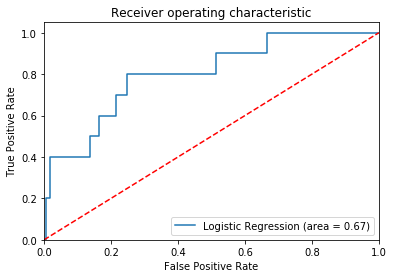

0.6655172413793103

In [134]:
####################################
#        ROC Curve
####################################
logit_roc_auc_2011 = roc_auc_score(y_2011_test, logreg_2011.predict(X_2011_test))
fpr_2011, tpr_2011, thresholds_2011 = roc_curve(y_2011_test, logreg_2011.predict_proba(X_2011_test)[:,1])
plt.figure()
plt.plot(fpr_2011, tpr_2011, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_2011)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

roc_auc_score(y_2011_test, logreg_2011.predict(X_2011_test))

In [135]:
########################################################################
########################################################################
#         07 + 09 + 11 --> 2012
########################################################################
########################################################################
train_070911 = train[(train['Yr_2007'] == 1) | (train['Yr_2009'] == 1) | (train['Yr_2011'] == 1)]
y_070911 = train_070911['WnvPresent']
X_070911 = train_070911.drop('WnvPresent', axis=1)
X_070911_train, X_070911_test, y_070911_train, y_070911_test = train_test_split(X_070911, y_070911, test_size=0.3, random_state=0)
logreg = LogisticRegression(random_state=42, class_weight='balanced')
parameters={'C':[0.001, 0.01, 0.1, 1], 'penalty':['l1', 'l2']}
gs_logreg = GridSearchCV(logreg, parameters, cv=5,n_jobs=-1,return_train_score=True,scoring='f1')
gs_logreg.fit(X_070911_train, y_070911_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [136]:
gs_logreg.cv_results_

{'mean_fit_time': array([ 0.61492491,  0.09908175, 11.98392701,  0.13640995, 11.22193785,
         0.28405008, 32.04610672,  0.54568939]),
 'std_fit_time': array([9.10552352e-02, 2.13137400e-02, 5.26736160e+00, 4.44498975e-03,
        2.25125368e+00, 1.72234499e-02, 5.81523864e+00, 7.42066385e-02]),
 'mean_score_time': array([0.00730314, 0.00353169, 0.00437474, 0.00286617, 0.00324011,
        0.00305114, 0.00242643, 0.00279903]),
 'std_score_time': array([0.00353824, 0.00047991, 0.00260416, 0.00040359, 0.00064577,
        0.00044293, 0.00067674, 0.0003541 ]),
 'param_C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1, 1],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C'

In [137]:
gs_logreg.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [138]:
logreg_070911 = LogisticRegression(C=0.1, class_weight='balanced', penalty='l2', random_state=42, solver='liblinear')
logreg_070911.fit(X_070911_train, y_070911_train)
y_070911_pred = logreg_070911.predict(X_070911_test)
print('Accuracy of logistic regression classifier on test set for 2007, 2009, & 2011: {:.2f}'.format(logreg_070911.score(X_070911_test, y_070911_test)))

Accuracy of logistic regression classifier on test set for 2007, 2009, & 2011: 0.81


[[1510  362]
 [  13   54]]


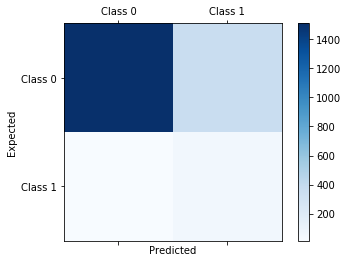

In [139]:
####################################
#        Confusion Matrix
####################################
#from sklearn.metrics import confusion_matrix
confusion_matrix_070911 = confusion_matrix(y_070911_test, y_070911_pred)
print(confusion_matrix_070911)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix_070911, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [140]:
####################################
#        Classification Report
####################################
print(classification_report(y_070911_test, y_070911_pred))

             precision    recall  f1-score   support

        0.0       0.99      0.81      0.89      1872
        1.0       0.13      0.81      0.22        67

avg / total       0.96      0.81      0.87      1939



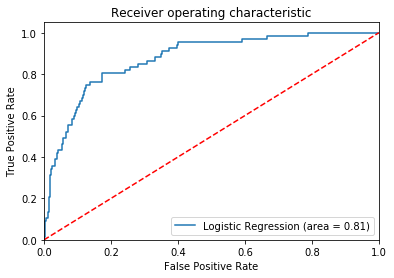

0.8062970404388315

In [141]:
####################################
#        ROC Curve
####################################
logit_roc_auc_070911 = roc_auc_score(y_070911_test, logreg_070911.predict(X_070911_test))
fpr_070911, tpr_070911, thresholds_070911 = roc_curve(y_070911_test, logreg_070911.predict_proba(X_070911_test)[:,1])
plt.figure()
plt.plot(fpr_070911, tpr_070911, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_070911)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

roc_auc_score(y_070911_test, logreg_070911.predict(X_070911_test))

In [142]:
########################################################################
########################################################################
#         2013 --> 2014
########################################################################
########################################################################
                                      
train_2013 = train[(train['Yr_2007'] == 0) & (train['Yr_2009'] == 0) & (train['Yr_2011'] == 0)]
y_2013 = train_2013['WnvPresent']
X_2013 = train_2013.drop('WnvPresent', axis=1)
X_2013_train, X_2013_test, y_2013_train, y_2013_test = train_test_split(X_2013, y_2013, test_size=0.3, random_state=0)
logreg = LogisticRegression(random_state=42, class_weight='balanced')
parameters={'C':[0.001, 0.01, 0.1, 1], 'penalty':['l1', 'l2']}
gs_logreg = GridSearchCV(logreg, parameters, cv=5,n_jobs=-1,return_train_score=True,scoring='f1')
gs_logreg.fit(X_2013_train, y_2013_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [143]:
gs_logreg.cv_results_

{'mean_fit_time': array([0.02769785, 0.02052321, 1.96233296, 0.02677546, 3.49491701,
        0.04674449, 5.06176023, 0.06993103]),
 'std_fit_time': array([0.00916213, 0.00295572, 0.62120129, 0.0016663 , 1.03698477,
        0.00539139, 1.39408545, 0.01332769]),
 'mean_score_time': array([0.00620656, 0.00233278, 0.0016232 , 0.00164933, 0.00185399,
        0.00188508, 0.00121603, 0.00169725]),
 'std_score_time': array([4.09164644e-03, 7.08378658e-04, 4.36131124e-05, 1.37063969e-04,
        3.65430819e-04, 5.50898630e-04, 1.26932995e-04, 4.26903000e-04]),
 'param_C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1, 1],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001,

In [144]:
gs_logreg.best_estimator_

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [145]:
logreg_2013 = LogisticRegression(C=0.1, class_weight='balanced', penalty='l2', random_state=42, solver='liblinear')
logreg_2013.fit(X_2013_train, y_2013_train)
y_2013_pred = logreg_2013.predict(X_2013_test)
print('Accuracy of logistic regression classifier on test set for 2013: {:.2f}'.format(logreg_2013.score(X_2013_test, y_2013_test)))

Accuracy of logistic regression classifier on test set for 2013: 0.63


[[341 210]
 [ 15  38]]


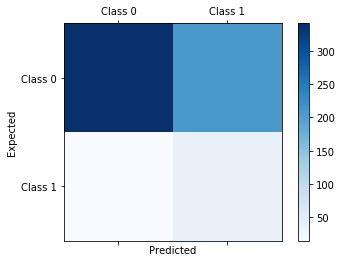

In [146]:
####################################
#        Confusion Matrix
####################################
#from sklearn.metrics import confusion_matrix
confusion_matrix_2013 = confusion_matrix(y_2013_test, y_2013_pred)
print(confusion_matrix_2013)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix_2013, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [147]:
####################################
#        Classification Report
####################################
print(classification_report(y_2013_test, y_2013_pred))

             precision    recall  f1-score   support

        0.0       0.96      0.62      0.75       551
        1.0       0.15      0.72      0.25        53

avg / total       0.89      0.63      0.71       604



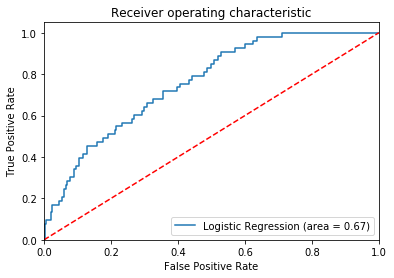

0.5631099544567338

In [148]:
####################################
#        ROC Curve
####################################
logit_roc_auc_2013 = roc_auc_score(y_2013_test, logreg_2013.predict(X_2013_test))
fpr_2013, tpr_2013, thresholds_2013 = roc_curve(y_2013_test, logreg_2013.predict_proba(X_2013_test)[:,1])
plt.figure()
plt.plot(fpr_2013, tpr_2013, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_2013)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

roc_auc_score(y_2013_test, logreg_2011.predict(X_2013_test))

In [149]:
########################################################################
########################################################################
#         07 + 09 + 11 + 13 --> 2014
########################################################################
########################################################################
train_07091113 = train.copy()
y_07091113 = train_07091113['WnvPresent']
X_07091113 = train_07091113.drop('WnvPresent', axis=1)
X_07091113_train, X_07091113_test, y_07091113_train, y_07091113_test = train_test_split(X_07091113, y_07091113, test_size=0.3, random_state=0)
logreg = LogisticRegression(random_state=42, class_weight='balanced')
parameters={'C':[0.001, 0.01, 0.1, 1], 'penalty':['l1', 'l2']}
gs_logreg = GridSearchCV(logreg, parameters, cv=5,n_jobs=-1,return_train_score=True,scoring='f1')
gs_logreg.fit(X_07091113_train, y_07091113_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [150]:
gs_logreg.cv_results_

{'mean_fit_time': array([ 1.42071972,  0.13587284, 13.01387076,  0.21052604, 33.73826809,
         0.44241519, 37.50696568,  0.71239257]),
 'std_fit_time': array([ 0.30025631,  0.01186983,  4.87499396,  0.01290468,  6.28217738,
         0.01197909, 10.93061407,  0.05499819]),
 'mean_score_time': array([0.01142912, 0.01076803, 0.0048512 , 0.00481496, 0.00435376,
        0.00479021, 0.00369635, 0.00448771]),
 'std_score_time': array([0.00335391, 0.00543715, 0.00063171, 0.00105736, 0.00086243,
        0.00075852, 0.00127824, 0.00073422]),
 'param_C': masked_array(data=[0.001, 0.001, 0.01, 0.01, 0.1, 0.1, 1, 1],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_penalty': masked_array(data=['l1', 'l2', 'l1', 'l2', 'l1', 'l2', 'l1', 'l2'],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001, 'penalty': 'l1'

In [151]:
gs_logreg.best_estimator_

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=42,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [152]:
logreg_07091113 = LogisticRegression(C=1, class_weight='balanced', penalty='l2', random_state=42, solver='liblinear')
logreg_07091113.fit(X_07091113_train, y_07091113_train)
y_07091113_pred = logreg_07091113.predict(X_07091113_test)
print('Accuracy of logistic regression classifier on test set for 2007, 2009, 2011, and 2013: {:.2f}'.format(logreg_07091113.score(X_07091113_test, y_07091113_test)))

Accuracy of logistic regression classifier on test set for 2007, 2009, 2011, and 2013: 0.79


[[1921  506]
 [  22   94]]


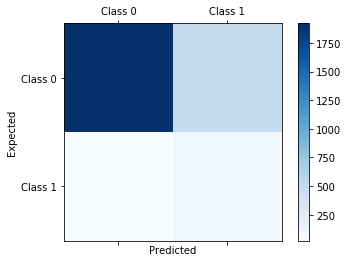

In [153]:
####################################
#        Confusion Matrix
####################################
#from sklearn.metrics import confusion_matrix
confusion_matrix_07091113 = confusion_matrix(y_07091113_test, y_07091113_pred)
print(confusion_matrix_07091113)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion_matrix_07091113, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

In [154]:
####################################
#        Classification Report
####################################
print(classification_report(y_07091113_test, y_07091113_pred))

             precision    recall  f1-score   support

        0.0       0.99      0.79      0.88      2427
        1.0       0.16      0.81      0.26       116

avg / total       0.95      0.79      0.85      2543



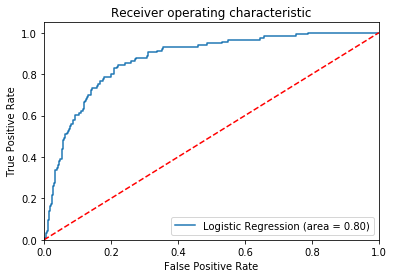

0.7227562053336744

In [155]:
####################################
#        ROC Curve
####################################
logit_roc_auc_07091113 = roc_auc_score(y_07091113_test, logreg_07091113.predict(X_07091113_test))
fpr_07091113, tpr_07091113, thresholds_07091113 = roc_curve(y_07091113_test, logreg_07091113.predict_proba(X_07091113_test)[:,1])
plt.figure()
plt.plot(fpr_07091113, tpr_07091113, label='Logistic Regression (area = %0.2f)' % logit_roc_auc_07091113)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

roc_auc_score(y_07091113_test, logreg_070911.predict(X_07091113_test))

# Models - Testing on Test Data <a name="testing"></a>

For 2008, I will be using logreg_2007, as it is the only choice.
For both 2010 and 2012, logreg_2009 & logreg_2011 were the better options, respectively. However with their extremely high AUC values, I am skeptical that my model may be over fit. Thus, I chose to use the models using all prior information, ie. using logreg_0709 and logreg_070911, resp. And finally for 2014, I used all prior data for prediction. Using only 2013 data resulted in a very low AUC (just over 50%). This might be indicitive of a change in the features of WVN as compared to other years.  

## Testing 2008 Data <a name="test2008"></a>

In [156]:
# Testing Data:
test_2008 = test[test['Yr_2008'] == 1]
X_2008_test = test_2008.drop('WnvPresent', axis=1)

y_2008_train = train_2007['WnvPresent']
X_2008_train = train_2007.drop('WnvPresent', axis=1)

logreg_2007.fit(X_2008_train, y_2008_train)
y_2008_pred = logreg_2007.predict(X_2008_test)

## Testing 2010 Data <a name="test2010"></a>

In [157]:
# Testing Data:
test_2010 = test[test['Yr_2010'] == 1]
X_2010_test = test_2010.drop('WnvPresent', axis=1)

# Training Data:
y_2010_train = train_0709['WnvPresent']
X_2010_train = train_0709.drop('WnvPresent', axis =1)

# Running Logistic Regression
logreg_0709.fit(X_2010_train, y_2010_train)
y_2010_pred = logreg_0709.predict(X_2010_test)

## Testing 2012 Data <a name="test2012"></a>

In [158]:
# Testing Data:
test_2012 = test[test['Yr_2012'] == 1]
X_2012_test = test_2012.drop('WnvPresent', axis=1)

y_2012_train = train_070911['WnvPresent']
X_2012_train = train_070911.drop('WnvPresent', axis=1)

logreg_070911.fit(X_2012_train, y_2012_train)
y_2012_pred = logreg_070911.predict(X_2012_test)

## Testing 2014 Data <a name="test2014"></a>

In [159]:
# Testing Data:
test_2014 = test[(test['Yr_2008'] == 0) & (test['Yr_2010'] == 0) & (test['Yr_2012'] == 0)]
X_2014_test = test_2014.drop('WnvPresent', axis=1)

y_2014_train = train_07091113['WnvPresent']
X_2014_train = train_07091113.drop('WnvPresent', axis =1)

logreg_07091113.fit(X_2014_train, y_2014_train)
y_2014_pred = logreg_07091113.predict(X_2014_test)

## Predictions <a name="predict"></a>

In [160]:
predictions = list(y_2008_pred) + list(y_2010_pred) + list(y_2012_pred) + list(y_2014_pred)

In [161]:
se = pd.Series(predictions)
test_ids['WnvPresent_predict'] = se.values

In [162]:
test_ids.to_csv('WNV_predictions.csv')

In [163]:
test_ids['WnvPresent_predict'].value_counts()

0.0    107154
1.0      9139
Name: WnvPresent_predict, dtype: int64

In [164]:
9139/(9139+107154)

0.0785859853989492

Thus, for the models predicted that a total of 9,139 of the test data records are positive for WNV. That is approiximately 7.86%

# Conculsion <a name="conclusion"></a>

As pervious mentioned, I used 2007 to predict 2008; 2007 & 2009 to predict 2010; 2007, 2009, 2011 to predict 2014; and 2007, 2009, 2011, 2013 (ie all training data) to predict 2014. I merged all of these predictions together to then have a final prediction for the Test data, which was saved out as "Wnv_predictions.csv"; this was the required submission for the competition.

I chose to use Logistic Regression because of the fact that this was a binary classification problem. I ultimately chose to optimize for f1. I could have optimized for precision, if say money for spraying pesticides to control WNV was a huge concern. Alternatively, I could have optimized for recall because, from the standpoint of the city of Chicago, telling people they are safe to go outside when in reality they are not (ie not properly classifying WNV as such) would do harm to the residents. Optimizing for recall would have been an acceptable route, however I chose to optimize for F1 since it is a balance between both precision and recall and takes into account the cost of potentially spraying as well as the health and safety of the residents of Chicago.

Overall, I predicted WNV in about 7.86% of the records in the Test data. This number is inline with the amount of WNV found in the training data, as there was 6.2% in 2007, 0.84% in 2009, 2.76% in 2011 and 9.99% in 2013. Also note that the very small cases in both 2009 and 2011 could be the reason for my over 95.5% AUC for those years individually and further justifies why I chose to go with joint models to predict 2010 and 2012 instead of just the data from the year prior.



### In Summary

There were many issues with the data.

First, with the weather data, it appeared that Station 2 did not collect as much weather information as Station 1, and so that data had to be interpreted. Essentially, for most of the missing data I tried to pull the information from the other station.

For the spray data, there were some missing times, which I fixed. However, I ultimately chose not to use this information as it was restricted to 2011 and 2013.

For the data itself, I chose to add a "daylight" feature which measured the amount of daylight in a given day, since the sunrise and sunset times were provided with the weather data. Also, since Mosquitos have a fairly short life cycle (about 2 weeks, but can vary from 4 days to a month according the epa.gov), I also chose to not only add the weather data for the date that the traps were checked, but also 4 days prior, as additional information. 



### With More Time....

If I had more time, I would have liked to try a combined classifier, if possible. For example to predict 2010 & 2012 & 2014, I would have liked to have 3 options for each:

2010:
    1. use only 2009
    2. Use 2007 & 2009 together
    3. a combined classifier of the one from 2007 together with (1).
2012:
    1. use only 2011 
    2. Use 2007, 2009, & 2011 together (as I did)
    3. a combination of the 2011 classifer plus classifer the best of (2) and (3) from 2010.
    4. then the 'best combined' classifer for 2012 would be the best of (2) and (3)
2014:
    1. use only 2013
    2. use all prior data together
    3. a combination of (1) plus the best of (2) and (3) from 2012, ie (4)
    
    
I looked into StackingClassifer from the mlxtend package, but it wasnt the correct method. Although this could be useful if I wanted to try to combine different classifiers, say RF and KNN with the Logistic Regression.

I also think I would like to look into elastic net for regularization to deal with the highly correlated weather data. I did try to use L1 or L2 as a penalty for this in my anaysis, based on the optimal result, but I would like to see the differnce with elastic net.

Also, I would have liked to look at the coefficients more to determine which features played a more important role and how this changed over time. From a quick initial glance, it may appear that the trap may have played an important role.

And looking at different time lags for the weather would be a good idea for the future as well. Perhaps, I could find the ideal lag. And finally, another direction I could take with more time is DLNM &/or krieging.